# 03. Нейросети и PyTorch

In [1]:
import random
import os
import torch
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

def plot_losses(losses, val_losses):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(losses, label='Ошибка обучения', c='b')
    plt.plot(val_losses, label='Ошибка валидации', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

## План
0. Переопределение `backward` (с прошлого семинара)
1. Готовим обучение
    1. Данные: `Dataset` & `DataLoader` 
    2. Модель: `nn.Module`
    3. Рутина: все остальное
2. Учим
    1. Baseline
    2. Stack more layers
3. I/O
4. Пример с картинками: MNIST

## 0. Переопределение `backward`

**Пользовательские функции**

**Зачем они нужны?**

* **Более эффективный расчёт** <br>
    Известен аналитический градиент, который лучше, чем автодифф суперпозиции функций.

* **Численная устойчивость**<br>
    Можно реализовать более стабильный алгоритм.

* **Интеграция внешнего кода**<br>
    Использование функций из сторонних библиотек.

* **Недифференцируемые функции**<br>
    Как быть с функциями, имеющими разрывы?..

### **Вычисление градиента для сигмоиды**

Рассмотрим функцию сигмоиды:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

Если явно разложить её на суперпозицию элементарных функций:

$$
\sigma(x) = f_4 \circ f_3 \circ f_2 \circ f_1(x),
$$

где
$$
\begin{aligned}
f_1(u) &= -u, \\
f_2(u) &= e^u, \\
f_3(u) &= 1 + u, \\
f_4(u) &= \frac{1}{u}.
\end{aligned}
$$

Тогда производная по правилу цепи:

$$
\frac{\partial \sigma}{\partial x} = \frac{\partial f_4}{\partial f_3} \cdot \frac{\partial f_3}{\partial f_2} \cdot \frac{\partial f_2}{\partial f_1} \cdot \frac{\partial f_1}{\partial x}.
$$

**Но**, зная структуру функции, можно получить изящное упрощение:

$$
\frac{\partial \sigma}{\partial x} = \sigma(x) \cdot (1 - \sigma(x)).
$$

Это показывает красоту аналитического подхода: вместо последовательного вычисления производных сложной цепи можно сразу получить компактное выражение через саму функцию.

### **Реализация градиента в PyTorch**

Для ручного задания правила вычисления градиента необходимо создать класс-наследник от [`torch.autograd.Function`](https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd).

**Задача:**
Реализуйте методы `forward()` и `backward()` для функции сигмоиды.

#### Ключевые моменты:

*   **`grad_output`** — градиент конечной функции потерь относительно выхода текущего слоя (результат предыдущего шага backprop)<br>
    *Обозначение: `grad_output` = $\frac{\partial L}{\partial z}$, где $z = f(x, y)$*
*   **`backward()`** должен возвращать градиент по входу текущего слоя $\left ( \frac{\partial L}{\partial x} \right )$
*   **`ctx`** (контекст) — объект для передачи данных между прямым и обратным проходом
*   Метод `ctx.save_for_backward()` сохраняет тензоры для использования в `backward()`


<svg version="1.1" xmlns="http://www.w3.org/2000/svg" viewBox="0 0 468.0458514960656 939.0826925507436" width="468.0458514960656" height="939.0826925507436" class="excalidraw-svg"><!-- svg-source:excalidraw --><metadata></metadata><defs><symbol id="image-8413015a34d2bdf1cdfd961883e741569dcf0ca0"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-2e6592db11d648622473170709d5251cd96b2f36"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-6c2f109911141052323e1b072e1a673e93964173"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-0f6e2d503e2a9b73d303295c81b556bc1bfdb566"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-2d068c9ceff62807aa5adbff0d4559bfef75b442"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-057216377b4519b3d46e0a51b7ab18a000bdf1aa"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-b30217e7c5afca87b8652718319d003550a8951b"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-4945074c217eb6d32968eb876b2307e4278805ee"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-13d3b486da0e53133f8fa45f8eb7c7db5ef8368d"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-c564f9a63b587363cea5aa5576709b07b5061eaf"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-9dd0140ebb8e7d02e3336863dcec451960ea651c"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-9deddbd7909b61fb71a73b11cf79fc41349ba7ff"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-d0fc12dbd004a0077ac5311ccb9c15dab232e0a6"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-e1cd894d4dda65c35b79aae2b624f5e0e0ae5f97"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-1868910e590be89b6a36c47dba29e38e46b8eecf"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-d4e891f76f3930d95affe3210cf386c4dacca0ab"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-15bde4dcbb8df05b2af921b791448d56e251492a"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><symbol id="image-35432801ee51f456ab806f665488c0995ef86868"><image href="" preserveAspectRatio="none" width="100%" height="100%"></image></symbol><style class="style-fonts">
      @font-face { font-family: Excalifont; src: url(data:font/woff2;base64,d09GMgABAAAAAAHwAA0AAAAABBAAAAGhAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGx4cNAZgADQRCAoALAsGAAE2AiQDCAQgBYMYByAbUwPIrgpscEcPjAqbbfFGeKx5Kz5EU3R4bDzUL93bvX8JXUVSmorE9SJxvRjNeBQOYXEOHSway/n/P+buVKO/qf2JJVWsT8RCwUokBQ4hUxIh0zx2kOoSixA6//37cw+I33LHb5EcSZbiLwn1l1CELdAXC7/Ia2HUcht7no7PES0JadRRYMAoA87WTvMJYgUaIDBgDsM3u00398MKuofDeAnda/+0gQ7Y6yWfIrW+/EzgUNU4x/xDBFjZOqq08QNClf+f6uoSTsInxFsCk8RIVOjgCel8k6AoApMN3NH0cADRkCBBwaAYFwg+3u9CxZ9YxvsDevfuFsDP16+mlcs86JMgeJ5qrXFd4uBUWQ2UIgTSN4QgEQJrAGg7xhNFAl79NkLHN9KIL1S6XlHMGqC2wm7dMgu23Qz1rcxNbG2cBDwYmzpb6Tt4MXZwNLe1QSKCwvXjrIqVu52ZIxIVxBC3KIZJ8px7SJ61Fz2qaMtGEnnLBb26c3cwNzVzQtyGPAgTxsSQgTtKV44c9F0FkZyVFcrjcfBYND7qYmwkiAc0qxEAAA==); }
      @font-face { font-family: Excalifont; src: url(data:font/woff2;base64,d09GMgABAAAAAAYQAA4AAAAACoQAAAW9AAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGhwbgRYcNAZgAEwRCAqLEIhPCxQAATYCJAMkBCAFgxgHIBs+CMiOw3Q7K9skyZc59/O4ae8nQdM6EqzLam50JnTGDGbGncOdg1d14nbQnKjXeMjfvX/OhPpTEBJCMZuoCAIlSEJWu+D/v3dfb5SOefxPwaKEE2vf1rY20NPaYiWULXvUGpZt8c0FiB8kYM223CAYQdQ1xBHyk/UijzS0vAgQADcACQaDXJfAhiAAfLGyEVNxZSNI950aNUgPjWodSK9lWzaAFAGmB1NxqjQbgAsOEwImRrgwoQ8GKBQLw4bi7I/QeD9O5IiKBQcciCwOFdLFi7fklwWAUg6bG43oDWDhhh5rAYAK9kYbxPsfrDBjC5eSarhMUEQxvm1GD6yNirbRAJ0AAOiJl4HG7QHcLyhop4qQinyHhsGSIpKIDKK4isMUKbdMfjf5YPL+5FVAgOiFP24/7/L7ZPQD9ANgPcDHkgB/5RZ5RmOYIDkmRhKXULzMPIJ0Moc/0jU7GxvbKWugka9HKEDXLO1odoyShmFh99ymJkbpkNplvaTB1N8OxjaBlVKAC2xyI2UdUvYwBYxSPCi84Zrb7Szs4+vLg63Q7So5UREyWDIogfOJgc5kZ/OEsp80mfoNBnLwksxRHqw/PRRKNZ2ckHUOBg0nuRiZ42yyM9XIN47IOkNuMcg+kXo62NwhdjBNJ1yUEfsPCfoSXS6509mkVyrNdrHY4egcJQ3j3V1OoD9lhKWJ2ahq79NJHebrAxhl7thl5/mnsrxAH9w8gnSWwRCDrX086NQ9x2iIYRjAqWx38vVSu3JgIsSCkHlEbB8VGhpNXQCDSibohLyt0dX0IMpko4zHRearoqfNK3SdDPI3Xr8eaHVau+TORiN/oCNicNTicHSKLQwjttwiDQzZP0y1CbtBUYdOSpsGziI/RoYY0gAHKGd3N5xiQhy6OXqEdCKkGyVJU7sNDtAguF3UDZC/cMBqtBrlHx5B31GZzs8idvL1A67Uz7VenFm1QFTlZS5qWaxqnP+m+EfdN4Iwf/nMEO+Ej8ytWrCfcsuvMvqhXPZf/cebNxcnpG87G8fr8XiBDt2ClavicN9bakJJ+YYtgpD1emDr2uy6Sur3FZc31+UEE3XzcJEwQf3xHY/B5ZXP+upufVCgCfIXfP5CraiuhsgPKwyY//12lvavPL4Ca/gy4bXNQsG9+FXd0O91uUooCFryad6nZaALzEIXf61jIy391xq2rvi13Smea7bjlroF34SrKJN4Be/33JD1ZM1DVXdBzfyF3KLcFCLfXgv7aqr7Bu7Inw8qOb6BJ970FWlzwjhlHhRb81po8WQrJftaQu7mxuAfsWl53B5WFb6n5H9TRv6vXb+Q4UfpUKFiXYVXdGUu/84zN1rO5EyOBfu2ePjM2w/jm4V0ha98MpBXNoGVnur13It5krGTj7OxrW55JHolP9GymdGbz36yqcynLtmr/CeVYX3VjeW7RozPBsOOGXFg3oAvXf5cXg2vtOpqt6S8QuHl990HZWVHpt6v/aiay63i5VeNh6XSS0hv7aOwXkXBsUXtP/13CbZ1uQpRFtLKeFhvYlKDz29EPWutB6izdk5fAAqRIIS5n/fwnvpDKJzzAhKICI17UswX4RRHwQtK3dD/zZtvtPbF5Ltl68SleO2UALgmDNadfGOJZ+ZfXBL/FgDgs53hhQAAn/f8sHv2uZndxPdEGgBwYbtz6kVaH0c5PdUBEOzGa5ZDUaghPyQgK9MQET6Qt9K8ITkCwbP8D5kBCfAwwHbkAsoC5GYs4pgPh5IHAGpPjUUELrIYD4dZXLgXWEKg5SxLtkBk62EBiuywwjJqa7TaaIMtotRTWWUrtWU0mqloaF27krQ40WLPzTKUUNtpk9W0aAmixRNDF4jvniIs3QzdnDZ6oQYlqmWEmrW9iwXMbLLTIayxyupB3w61QhhavFjxEtGW24mOfnIljWW2i0bLo6ZGx/3aBlUEFW5TYqVoONianQEWAA==); }</style></defs><rect x="0" y="0" width="468.0458514960656" height="939.0826925507436" fill="#ffffff"></rect><g stroke-linecap="round" transform="translate(10 10) rotate(0 30.277862548828125 30.277862548828125)"><path d="M29.26 0.94 C35.67 0.21, 44.22 2.72, 49.37 6.31 C54.52 9.9, 58.71 16.04, 60.15 22.47 C61.59 28.9, 60.94 39.1, 58 44.89 C55.06 50.68, 48.65 54.95, 42.5 57.21 C36.34 59.47, 27.33 60.17, 21.08 58.45 C14.84 56.74, 8.52 52.13, 5.03 46.91 C1.54 41.69, -0.75 33.62, 0.15 27.13 C1.05 20.64, 4.32 12.21, 10.43 7.95 C16.53 3.7, 31.18 2.08, 36.78 1.59 C42.38 1.11, 44.09 4.84, 44.01 5.04 M42.93 3.89 C49.01 5.98, 55.71 9.79, 58.35 15.41 C60.98 21.03, 60.38 31.18, 58.73 37.61 C57.08 44.04, 53.5 49.94, 48.47 53.98 C43.44 58.02, 34.92 62.34, 28.54 61.84 C22.15 61.34, 14.98 55.64, 10.15 50.98 C5.32 46.31, 0.58 40.23, -0.45 33.86 C-1.49 27.49, 0.27 18.14, 3.96 12.76 C7.64 7.38, 15.46 3.32, 21.65 1.58 C27.83 -0.17, 37.64 2.13, 41.07 2.3 C44.49 2.46, 41.99 2.17, 42.19 2.58" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g stroke-linecap="round" transform="translate(19.925018310546875 158.38363647460938) rotate(0 30.277862548828125 30.277862548828125)"><path d="M43.95 3.04 C49.6 5.38, 55.45 12.75, 58.1 18.77 C60.76 24.78, 61.66 33.07, 59.89 39.12 C58.12 45.18, 53.08 51.56, 47.48 55.08 C41.88 58.59, 32.69 60.79, 26.29 60.22 C19.89 59.64, 13.42 56.29, 9.07 51.61 C4.73 46.93, 0.65 38.79, 0.22 32.14 C-0.22 25.48, 2.53 17, 6.47 11.68 C10.41 6.37, 17.37 1.57, 23.86 0.24 C30.35 -1.1, 41.7 2.81, 45.41 3.68 C49.12 4.55, 46.35 5.01, 46.12 5.44 M27.26 -0.26 C33.41 -1.43, 43.76 0.64, 49.35 4.39 C54.93 8.14, 59.31 15.99, 60.78 22.26 C62.25 28.53, 61.13 35.93, 58.17 42.02 C55.2 48.12, 48.85 56.01, 43 58.83 C37.15 61.65, 29.38 60.74, 23.05 58.95 C16.72 57.15, 8.71 53.1, 5.01 48.06 C1.32 43.02, 0.36 35.42, 0.87 28.72 C1.38 22.01, 3.51 12.72, 8.08 7.84 C12.65 2.96, 25.08 0.47, 28.29 -0.56 C31.5 -1.58, 27.51 0.87, 27.35 1.7" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g stroke-linecap="round" transform="translate(149.44936263650817 61.310089111328125) rotate(0 59.3770490284256 53.100494384765625)"><path d="M81.5 4.01 C90.54 6.21, 100.09 12.06, 106.33 19.06 C112.57 26.06, 117.65 37.03, 118.96 46.01 C120.28 54.98, 117.94 64.89, 114.21 72.92 C110.48 80.94, 104.07 88.79, 96.57 94.18 C89.07 99.56, 78.99 103.77, 69.22 105.23 C59.45 106.69, 47.41 105.95, 37.95 102.91 C28.48 99.87, 18.54 94.03, 12.42 86.99 C6.3 79.95, 2.73 69.47, 1.2 60.69 C-0.33 51.9, -0.26 42.39, 3.25 34.29 C6.75 26.18, 14.43 17.6, 22.25 12.06 C30.06 6.52, 38.99 1.83, 50.14 1.05 C61.29 0.28, 81.74 5.53, 89.14 7.41 C96.53 9.28, 95.07 11.55, 94.51 12.31 M54.31 -0.95 C63.95 -1.95, 77.95 2.64, 87.07 6.51 C96.19 10.39, 103.68 15.23, 109.03 22.31 C114.37 29.4, 118.59 40.05, 119.12 49.03 C119.66 58.02, 116.59 68.37, 112.22 76.21 C107.86 84.05, 100.92 90.89, 92.94 96.08 C84.96 101.27, 74.23 106.6, 64.33 107.36 C54.44 108.12, 42.46 104.89, 33.57 100.65 C24.68 96.41, 16.57 89.36, 10.97 81.92 C5.37 74.47, 0.87 64.62, -0.03 55.99 C-0.94 47.35, 1.26 38.11, 5.56 30.11 C9.85 22.11, 17.32 13.23, 25.74 7.99 C34.16 2.76, 51 -0.09, 56.06 -1.29 C61.13 -2.49, 56.09 -0.57, 56.13 0.79" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g stroke-linecap="round"><g transform="translate(80.34295541864745 39.75919419380401) rotate(0 39.01370095283639 16.509484336224403)"><path d="M-0.43 -0.09 C12.65 5.35, 64.36 27.31, 77.33 32.89 M1.55 -1.18 C15.12 4.43, 67.22 28.96, 79.67 34.36" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(80.34295541864745 39.75919419380401) rotate(0 39.01370095283639 16.509484336224403)"><path d="M54.75 32.42 C59.69 31.74, 64.71 32.2, 79.67 34.36 M54.75 32.42 C62.42 33.68, 71.35 33.74, 79.67 34.36" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(80.34295541864745 39.75919419380401) rotate(0 39.01370095283639 16.509484336224403)"><path d="M61.82 16.86 C65.35 19.32, 68.92 22.97, 79.67 34.36 M61.82 16.86 C67.09 23.19, 73.68 28.38, 79.67 34.36" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(146.39363030307996 112.64185752202883) rotate(0 -39.49415561524508 -22.32669863746422)"><path d="M0.53 0.13 C-12.64 -7.26, -65.63 -36.68, -78.77 -43.99 M-0.66 -0.84 C-13.98 -8.62, -66.59 -38.31, -79.6 -45.76" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(146.39363030307996 112.64185752202883) rotate(0 -39.49415561524508 -22.32669863746422)"><path d="M-54.96 -41.59 C-62.59 -42.45, -69.54 -43.02, -79.6 -45.76 M-54.96 -41.59 C-63.65 -42.97, -74.45 -45.64, -79.6 -45.76" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(146.39363030307996 112.64185752202883) rotate(0 -39.49415561524508 -22.32669863746422)"><path d="M-63.4 -26.72 C-68.39 -32.35, -72.66 -37.65, -79.6 -45.76 M-63.4 -26.72 C-68.81 -33.69, -76.41 -42, -79.6 -45.76" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(78.41280530710152 166.59966903936115) rotate(0 37.457753874587965 -15.441891549188314)"><path d="M-0.06 0.8 C12.53 -4.27, 62.2 -24.89, 74.75 -30.12 M-1.56 0.17 C10.94 -5.26, 61.01 -26.96, 73.71 -31.85" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(78.41280530710152 166.59966903936115) rotate(0 37.457753874587965 -15.441891549188314)"><path d="M55.26 -14.98 C60.85 -19.17, 65.08 -22.26, 73.71 -31.85 M55.26 -14.98 C61.68 -20.52, 68.23 -26.55, 73.71 -31.85" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(78.41280530710152 166.59966903936115) rotate(0 37.457753874587965 -15.441891549188314)"><path d="M48.74 -30.79 C55.88 -31.3, 61.63 -30.7, 73.71 -31.85 M48.74 -30.79 C57.13 -31.16, 65.79 -32.07, 73.71 -31.85" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(161.95252400438068 156.61260299609899) rotate(0 -37.84253124452139 20.57244388385939)"><path d="M-0.55 1.17 C-13.19 8.06, -63.94 34.22, -76.42 41.08 M1.36 0.74 C-10.84 7.85, -61.19 35.94, -74.1 42.58" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(161.95252400438068 156.61260299609899) rotate(0 -37.84253124452139 20.57244388385939)"><path d="M-57.48 23.9 C-59.73 27.27, -65.96 33.57, -74.1 42.58 M-57.48 23.9 C-63.2 31.83, -70.25 38.87, -74.1 42.58" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(161.95252400438068 156.61260299609899) rotate(0 -37.84253124452139 20.57244388385939)"><path d="M-49.36 38.95 C-53.61 38.51, -61.87 41.05, -74.1 42.58 M-49.36 38.95 C-58.24 40.94, -68.49 42.03, -74.1 42.58" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(269.592636432173 98.01706252061477) rotate(0 55.33301528000726 -0.6235825298386359)"><path d="M0.7 -0.05 C19.36 -0.07, 92.56 -0.94, 110.83 -1.25 M-0.39 -1.12 C18.23 -0.84, 91.67 0.25, 109.97 0.29" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(269.592636432173 98.01706252061477) rotate(0 55.33301528000726 -0.6235825298386359)"><path d="M86.39 8.62 C91.24 7.04, 96.16 4.52, 109.97 0.29 M86.39 8.62 C92.19 7.42, 97.28 5.21, 109.97 0.29" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(269.592636432173 98.01706252061477) rotate(0 55.33301528000726 -0.6235825298386359)"><path d="M86.56 -8.48 C91.21 -6.54, 96.1 -5.55, 109.97 0.29 M86.56 -8.48 C92.33 -5.43, 97.38 -3.39, 109.97 0.29" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(374.433349609375 131.93475341796875) rotate(0 -53.616241455078125 -0.33587646484375)"><path d="M-0.28 -0.74 C-18.07 -0.8, -88.37 -0.38, -106.08 -0.55 M1.78 1.48 C-16.12 1.65, -88.31 1.47, -106.42 1.05" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(374.433349609375 131.93475341796875) rotate(0 -53.616241455078125 -0.33587646484375)"><path d="M-82.83 -7.24 C-92.46 -2.42, -99.4 -0.19, -106.42 1.05 M-82.83 -7.24 C-88.29 -6.05, -92.93 -4.81, -106.42 1.05" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(374.433349609375 131.93475341796875) rotate(0 -53.616241455078125 -0.33587646484375)"><path d="M-83.02 9.86 C-92.55 8.6, -99.42 4.76, -106.42 1.05 M-83.02 9.86 C-88.33 7.52, -92.94 5.23, -106.42 1.05" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g transform="translate(89.5782470703125 15.49114990234375) rotate(0 8 3.5)"><use href="#image-35432801ee51f456ab806f665488c0995ef86868" width="16" height="7" opacity="1"></use></g><g transform="translate(171.6441650390625 72.31903076171875) rotate(0 13 17)"><use href="#image-15bde4dcbb8df05b2af921b791448d56e251492a" width="26" height="34" opacity="1"></use></g><g transform="translate(302.531474482148 153.0582357981834) rotate(0 13.5 17)"><use href="#image-d4e891f76f3930d95affe3210cf386c4dacca0ab" width="27" height="34" opacity="1"></use></g><g transform="translate(289.21954345703125 71.5810546875) rotate(0 7.5 3.5)"><use href="#image-1868910e590be89b6a36c47dba29e38e46b8eecf" width="15" height="7" opacity="1"></use></g><g transform="translate(200.21124267578125 109.52099609375) rotate(0 8 7.5)"><use href="#image-e1cd894d4dda65c35b79aae2b624f5e0e0ae5f97" width="16" height="15" opacity="1"></use></g><g transform="translate(83.43110378962425 209.72787582695588) rotate(0 49.74434641243163 18.22317640851456)"><use href="#image-d0fc12dbd004a0077ac5311ccb9c15dab232e0a6" width="99" height="36" opacity="1"></use></g><g stroke-linecap="round"><g transform="translate(59.373193730354984 657.335189872924) rotate(0 0 -100.5030517578125)"><path d="M-0.16 -0.66 C0.06 -33.95, 0.96 -167.32, 1.1 -200.83 M-1.7 1.6 C-1.53 -31.37, 0.4 -165.47, 0.73 -199.21" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(59.373193730354984 657.335189872924) rotate(0 0 -100.5030517578125)"><path d="M8.99 -175.61 C5.75 -180.51, 4.79 -187.91, 0.73 -199.21 M8.99 -175.61 C6.47 -180.41, 4.81 -187.19, 0.73 -199.21" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(59.373193730354984 657.335189872924) rotate(0 0 -100.5030517578125)"><path d="M-8.11 -175.82 C-6.48 -180.63, -2.57 -187.98, 0.73 -199.21 M-8.11 -175.82 C-6.58 -180.71, -4.18 -187.44, 0.73 -199.21" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(39.656260195087356 650.1177736190937) rotate(0 120.4450146191963 0)"><path d="M0.54 0.71 C40.55 0.92, 200.76 1.08, 240.96 0.99 M-0.64 0.04 C39.14 -0.05, 199.7 -0.86, 240.05 -0.62" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(39.656260195087356 650.1177736190937) rotate(0 120.4450146191963 0)"><path d="M216.56 7.94 C226.6 4.74, 235.88 2.86, 240.05 -0.62 M216.56 7.94 C223.21 6.26, 230.53 2.65, 240.05 -0.62" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(39.656260195087356 650.1177736190937) rotate(0 120.4450146191963 0)"><path d="M216.56 -9.16 C226.56 -5.94, 235.85 -1.39, 240.05 -0.62 M216.56 -9.16 C223.17 -5.54, 230.49 -3.85, 240.05 -0.62" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g transform="translate(80.7969608201987 460.461410576049) rotate(0 9 5.5)"><use href="#image-9deddbd7909b61fb71a73b11cf79fc41349ba7ff" width="18" height="11" opacity="1"></use></g><g transform="translate(100.73439978504246 510.60990911120524) rotate(0 101.49603271484375 42.959686279296875)" stroke="none"><path fill="#1e1e1e" d="M 0.46,-0.90 Q 0.46,-0.90 1.13,-0.58 1.81,-0.25 2.38,0.06 2.94,0.38 3.35,0.77 3.77,1.15 4.53,2.20 5.29,3.24 5.82,4.43 6.35,5.62 7.01,7.12 7.66,8.62 8.17,9.68 8.68,10.73 9.35,12.26 10.03,13.78 10.92,14.98 11.81,16.17 12.67,16.88 13.53,17.59 14.50,17.95 15.47,18.32 16.78,18.48 18.09,18.64 19.41,18.72 20.73,18.80 21.76,18.83 22.80,18.86 23.88,18.94 24.95,19.02 26.07,19.59 27.19,20.16 28.15,21.46 29.10,22.75 29.74,23.98 30.37,25.20 30.95,26.59 31.52,27.98 32.06,29.42 32.59,30.85 32.93,31.78 33.26,32.70 33.63,33.42 34.00,34.14 34.42,34.71 34.84,35.28 35.58,35.77 36.31,36.26 37.29,36.82 38.26,37.38 39.44,37.90 40.63,38.41 42.46,38.97 44.29,39.53 45.80,39.96 47.32,40.39 48.85,40.88 50.39,41.36 51.65,41.74 52.91,42.12 53.83,42.43 54.75,42.74 55.41,42.93 56.07,43.12 56.67,43.44 57.26,43.76 57.90,44.43 58.53,45.10 59.04,45.72 59.55,46.34 60.07,46.99 60.60,47.64 61.50,48.51 62.41,49.38 63.74,50.07 65.06,50.76 66.69,51.21 68.31,51.66 70.27,51.86 72.22,52.07 73.95,52.16 75.68,52.26 77.42,52.26 79.16,52.26 80.75,52.12 82.34,51.98 83.46,51.92 84.57,51.86 85.40,51.79 86.23,51.72 86.86,51.76 87.50,51.81 88.09,52.25 88.67,52.70 89.04,53.27 89.41,53.84 89.69,54.38 89.96,54.92 90.32,55.70 90.68,56.48 91.13,57.00 91.58,57.53 92.65,58.26 93.71,58.99 94.28,59.40 94.85,59.81 95.38,60.20 95.92,60.60 96.47,61.11 97.02,61.61 97.56,62.27 98.11,62.92 98.51,63.60 98.92,64.28 99.27,64.92 99.62,65.56 99.91,66.25 100.21,66.93 100.46,67.75 100.71,68.56 100.93,69.40 101.15,70.23 101.48,71.17 101.82,72.10 102.27,72.60 102.71,73.10 103.12,73.47 103.53,73.84 103.87,74.74 104.22,75.63 104.28,76.33 104.34,77.03 104.35,77.69 104.36,78.35 104.36,78.95 104.36,79.56 104.39,80.23 104.42,80.90 105.55,81.20 106.69,81.50 107.88,81.84 109.06,82.19 110.38,82.62 111.70,83.05 113.07,83.40 114.44,83.75 115.58,84.04 116.73,84.32 117.60,84.53 118.47,84.73 119.16,84.88 119.85,85.03 120.39,85.06 120.92,85.09 121.91,85.07 122.91,85.05 123.62,84.94 124.33,84.82 125.17,84.60 126.00,84.38 127.07,84.14 128.13,83.90 129.19,83.55 130.24,83.20 131.20,82.84 132.15,82.47 133.10,82.12 134.05,81.76 134.92,81.37 135.79,80.99 136.60,80.55 137.41,80.11 138.09,79.65 138.78,79.20 139.57,78.60 140.37,77.99 141.07,77.45 141.77,76.91 142.39,76.34 143.01,75.76 143.79,75.00 144.57,74.23 145.39,73.43 146.22,72.63 146.97,71.94 147.72,71.26 148.43,70.68 149.13,70.10 149.78,69.66 150.43,69.21 151.14,68.89 151.84,68.57 152.92,68.45 154.00,68.33 154.78,68.26 155.57,68.19 156.78,68.21 157.99,68.24 159.15,68.31 160.31,68.39 161.35,68.60 162.39,68.81 163.48,69.17 164.56,69.53 165.32,69.73 166.07,69.93 166.75,70.11 167.44,70.29 167.99,70.41 168.54,70.52 169.00,70.23 169.46,69.94 169.68,69.41 169.89,68.87 170.07,68.03 170.24,67.19 170.50,66.17 170.75,65.14 171.01,64.05 171.28,62.96 171.42,62.03 171.57,61.11 171.81,60.00 172.05,58.90 172.32,57.93 172.58,56.95 173.24,55.40 173.90,53.84 174.60,52.63 175.29,51.42 175.81,50.49 176.34,49.57 176.96,48.64 177.58,47.70 178.08,46.84 178.58,45.97 179.18,45.01 179.78,44.05 180.51,42.67 181.23,41.28 181.87,40.17 182.52,39.06 183.42,37.52 184.32,35.98 184.99,34.96 185.67,33.94 186.55,32.88 187.44,31.83 188.24,31.03 189.05,30.23 189.77,29.49 190.50,28.76 191.17,28.10 191.84,27.44 192.50,26.80 193.17,26.16 193.80,25.61 194.44,25.07 195.28,24.46 196.12,23.84 196.79,23.27 197.47,22.70 198.12,22.19 198.77,21.67 200.47,20.77 202.18,19.86 202.33,19.83 202.49,19.80 202.65,19.83 202.80,19.85 202.95,19.92 203.09,19.99 203.20,20.10 203.31,20.21 203.38,20.36 203.45,20.50 203.47,20.66 203.49,20.81 203.46,20.97 203.43,21.13 203.35,21.26 203.27,21.40 203.15,21.51 203.04,21.61 202.89,21.67 202.74,21.74 202.59,21.75 202.43,21.76 202.27,21.72 202.12,21.68 201.99,21.60 201.85,21.51 201.75,21.39 201.66,21.26 201.60,21.11 201.55,20.96 201.54,20.80 201.54,20.65 201.59,20.49 201.64,20.34 201.73,20.21 201.82,20.09 201.95,19.99 202.08,19.90 202.23,19.86 202.38,19.81 202.54,19.82 202.70,19.82 202.85,19.88 203.00,19.93 203.12,20.03 203.24,20.13 203.33,20.27 203.41,20.40 203.45,20.55 203.49,20.71 203.48,20.87 203.46,21.02 203.40,21.17 203.34,21.32 203.23,21.43 203.12,21.55 202.98,21.63 202.85,21.71 202.85,21.71 202.85,21.70 201.34,22.41 199.83,23.11 199.18,23.55 198.53,24.00 197.81,24.56 197.09,25.13 196.28,25.76 195.48,26.39 194.84,26.84 194.21,27.29 193.52,27.90 192.83,28.51 192.14,29.11 191.45,29.71 190.72,30.44 189.98,31.16 189.22,31.93 188.46,32.69 187.62,33.68 186.78,34.67 186.13,35.66 185.48,36.66 184.59,38.20 183.69,39.74 183.07,40.83 182.44,41.91 181.71,43.35 180.97,44.79 180.39,45.74 179.80,46.68 179.28,47.58 178.75,48.47 178.17,49.37 177.60,50.27 177.09,51.20 176.59,52.14 175.96,53.29 175.33,54.44 174.75,55.91 174.16,57.37 173.91,58.29 173.67,59.21 173.49,60.29 173.32,61.37 173.18,62.34 173.04,63.31 172.86,64.41 172.68,65.52 172.53,66.54 172.39,67.55 172.23,68.69 172.08,69.82 171.71,70.59 171.35,71.36 170.68,71.98 170.00,72.61 168.99,72.54 167.98,72.47 167.42,72.26 166.86,72.06 166.20,71.80 165.55,71.55 164.83,71.28 164.11,71.00 163.09,70.71 162.07,70.41 161.16,70.23 160.24,70.05 159.13,70.04 158.02,70.02 156.85,70.09 155.68,70.15 154.95,70.17 154.21,70.19 153.37,70.28 152.53,70.38 151.95,70.57 151.36,70.75 150.75,71.08 150.14,71.40 149.45,71.90 148.77,72.40 148.05,73.06 147.33,73.72 146.54,74.55 145.76,75.38 144.97,76.24 144.19,77.09 143.49,77.69 142.80,78.28 142.09,78.79 141.39,79.29 140.55,79.98 139.71,80.67 138.95,81.12 138.19,81.58 137.32,82.03 136.46,82.48 135.55,82.88 134.64,83.29 133.71,83.66 132.79,84.03 131.83,84.45 130.87,84.87 129.76,85.32 128.66,85.78 127.65,86.12 126.63,86.46 125.67,86.78 124.71,87.10 123.78,87.26 122.86,87.42 121.76,87.31 120.66,87.20 120.00,87.08 119.34,86.96 118.68,86.75 118.02,86.54 117.19,86.33 116.35,86.12 115.19,85.93 114.02,85.73 112.57,85.49 111.12,85.25 109.83,85.00 108.54,84.75 107.21,84.59 105.88,84.42 105.19,84.25 104.50,84.08 103.63,83.75 102.76,83.42 102.26,82.81 101.77,82.21 101.58,81.68 101.39,81.15 101.38,80.38 101.38,79.60 101.36,79.02 101.35,78.44 101.32,77.86 101.29,77.28 101.09,76.35 100.90,75.41 100.50,74.99 100.10,74.57 99.79,73.96 99.49,73.36 99.33,72.66 99.18,71.97 99.02,71.43 98.86,70.89 98.61,70.11 98.36,69.32 98.12,68.62 97.88,67.92 97.64,67.35 97.41,66.78 97.06,66.16 96.72,65.55 96.45,65.05 96.18,64.55 95.72,64.03 95.25,63.50 94.81,63.08 94.38,62.67 93.86,62.27 93.34,61.88 92.82,61.50 92.29,61.12 91.58,60.67 90.86,60.23 90.37,59.88 89.88,59.52 89.38,59.00 88.87,58.48 88.61,57.90 88.35,57.32 88.13,56.57 87.91,55.82 87.57,54.92 87.23,54.02 86.75,53.64 86.27,53.26 85.46,53.24 84.65,53.22 83.56,53.29 82.47,53.36 80.82,53.52 79.16,53.68 77.39,53.69 75.61,53.71 73.84,53.64 72.08,53.57 69.99,53.38 67.91,53.20 66.11,52.73 64.31,52.27 62.76,51.51 61.20,50.75 60.12,49.83 59.03,48.91 58.50,48.24 57.96,47.57 57.52,46.97 57.08,46.37 56.28,45.52 55.49,44.67 54.87,44.39 54.26,44.10 53.39,43.76 52.52,43.43 51.25,43.05 49.98,42.67 48.46,42.21 46.94,41.74 45.41,41.32 43.88,40.91 41.97,40.34 40.05,39.77 38.78,39.25 37.51,38.73 36.46,38.17 35.40,37.60 34.42,36.92 33.44,36.24 33.02,35.52 32.59,34.79 32.26,33.97 31.93,33.15 31.64,32.23 31.35,31.32 30.82,29.90 30.29,28.49 29.74,27.15 29.19,25.81 28.60,24.67 28.01,23.53 27.26,22.42 26.51,21.32 25.66,20.85 24.81,20.38 23.78,20.31 22.76,20.24 21.71,20.21 20.65,20.18 19.28,20.11 17.91,20.04 16.44,19.85 14.97,19.67 13.79,19.21 12.61,18.75 11.60,17.94 10.58,17.12 9.56,15.81 8.53,14.49 7.82,13.02 7.11,11.56 6.51,10.51 5.91,9.46 5.16,8.04 4.42,6.61 3.78,5.53 3.13,4.44 2.57,3.58 2.01,2.72 1.44,2.17 0.86,1.61 0.20,1.26 -0.46,0.90 -0.56,0.84 -0.66,0.77 -0.74,0.68 -0.83,0.59 -0.88,0.48 -0.94,0.37 -0.97,0.25 -1.01,0.13 -1.01,0.01 -1.01,-0.10 -0.98,-0.22 -0.95,-0.34 -0.90,-0.45 -0.84,-0.56 -0.76,-0.66 -0.68,-0.75 -0.58,-0.82 -0.48,-0.89 -0.37,-0.94 -0.25,-0.98 -0.13,-1.00 -0.01,-1.01 0.10,-1.00 0.22,-0.99 0.34,-0.95 0.46,-0.90 0.46,-0.90 L 0.46,-0.90 Z"></path></g><g stroke-linecap="round"><g transform="translate(199.17204215484708 580.1664525394951) rotate(0 0 34.73962589372084)"><path d="M0 0 C0 11.58, 0 57.9, 0 69.48 M0 0 C0 11.58, 0 57.9, 0 69.48" stroke="#1e1e1e" stroke-width="0.5" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(224.4610233201987 597.1013248817567) rotate(0 -1.7763568394002505e-15 25.88795910691178)"><path d="M0 0 C0 8.63, 0 43.15, 0 51.78 M0 0 C0 8.63, 0 43.15, 0 51.78" stroke="#1e1e1e" stroke-width="0.5" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(197.10721117082971 662.0126054211652) rotate(0 14.391756348691374 -0.253042510824514)"><path d="M0 0 C4.8 -0.08, 23.99 -0.42, 28.78 -0.51 M0 0 C4.8 -0.08, 23.99 -0.42, 28.78 -0.51" stroke="#1e1e1e" stroke-width="0.5" fill="none"></path></g><g transform="translate(197.10721117082971 662.0126054211652) rotate(0 14.391756348691374 -0.253042510824514)"><path d="M15.35 4.65 C18.59 3.41, 21.83 2.17, 28.78 -0.51 M15.35 4.65 C20.25 2.77, 25.16 0.89, 28.78 -0.51" stroke="#1e1e1e" stroke-width="0.5" fill="none"></path></g><g transform="translate(197.10721117082971 662.0126054211652) rotate(0 14.391756348691374 -0.253042510824514)"><path d="M15.17 -5.19 C18.46 -4.06, 21.74 -2.93, 28.78 -0.51 M15.17 -5.19 C20.14 -3.48, 25.11 -1.77, 28.78 -0.51" stroke="#1e1e1e" stroke-width="0.5" fill="none"></path></g></g><mask></mask><g transform="translate(187.0440311326987 688.5196381151115) rotate(0 53 17.00000000000003)"><use href="#image-9dd0140ebb8e7d02e3336863dcec451960ea651c" width="106" height="34" opacity="1"></use></g><g stroke-linecap="round" transform="translate(152.60273094609673 317.20324696454577) rotate(0 30.277862548828125 30.277862548828125)"><path d="M42.68 2.85 C48.45 5.21, 54.34 11.92, 57.16 17.64 C59.98 23.36, 61.24 30.84, 59.6 37.16 C57.97 43.48, 52.66 51.65, 47.36 55.56 C42.07 59.47, 34.29 61.43, 27.84 60.64 C21.39 59.85, 13.3 55.33, 8.68 50.82 C4.07 46.32, 0.64 39.93, 0.14 33.61 C-0.36 27.29, 1.91 18.48, 5.71 12.91 C9.51 7.35, 16.19 1.54, 22.95 0.2 C29.7 -1.13, 42.17 3.83, 46.26 4.9 C50.35 5.98, 47.84 6.32, 47.49 6.64 M32.64 -0.2 C38.69 -0.22, 46.86 4.97, 51.71 9.43 C56.56 13.89, 60.91 20.11, 61.73 26.56 C62.56 33.01, 60.72 42.79, 56.64 48.14 C52.56 53.48, 43.69 57.22, 37.28 58.64 C30.87 60.05, 24.1 59.14, 18.19 56.62 C12.27 54.1, 4.86 49.39, 1.79 43.53 C-1.28 37.67, -2.21 27.68, -0.24 21.46 C1.73 15.24, 8.06 9.8, 13.63 6.18 C19.19 2.56, 30.29 0.6, 33.17 -0.28 C36.05 -1.17, 31.12 0.46, 30.9 0.9" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g stroke-linecap="round"><g transform="translate(76.76127689521483 333.80043559965077) rotate(0 37.85287759052084 0)"><path d="M1.12 0.98 C13.83 0.92, 62.87 -0.61, 75.35 -0.61 M0.25 0.45 C12.85 0.56, 61.69 0.82, 74.22 0.61" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(76.76127689521483 333.80043559965077) rotate(0 37.85287759052084 0)"><path d="M50.76 9.26 C57.76 6.49, 60.44 5.62, 74.22 0.61 M50.76 9.26 C60.26 6.21, 69.04 2.13, 74.22 0.61" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(76.76127689521483 333.80043559965077) rotate(0 37.85287759052084 0)"><path d="M50.69 -7.84 C57.67 -6.73, 60.37 -3.7, 74.22 0.61 M50.69 -7.84 C60.09 -4.35, 68.89 -1.88, 74.22 0.61" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(149.66037942498102 356.6889695563274) rotate(0 -34.110537723725905 -1.4210854715202004e-14)"><path d="M-0.87 1.05 C-12.13 1.03, -57.18 0.87, -68.29 0.64 M0.88 0.55 C-10.49 0.12, -57.8 -1.18, -69.27 -1.15" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(149.66037942498102 356.6889695563274) rotate(0 -34.110537723725905 -1.4210854715202004e-14)"><path d="M-45.65 -9.35 C-49.54 -7.66, -55.9 -4.43, -69.27 -1.15 M-45.65 -9.35 C-51.12 -6.44, -58.58 -5.13, -69.27 -1.15" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(149.66037942498102 356.6889695563274) rotate(0 -34.110537723725905 -1.4210854715202004e-14)"><path d="M-45.91 7.75 C-49.84 5.33, -56.13 4.45, -69.27 -1.15 M-45.91 7.75 C-51.21 6.04, -58.61 2.74, -69.27 -1.15" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round" transform="translate(287.53868404539367 317.3758466487444) rotate(0 30.277862548828125 30.277862548828125)"><path d="M16.47 2.68 C21.56 -0.49, 30.05 0.02, 36.42 1.58 C42.79 3.14, 50.8 7.2, 54.67 12.04 C58.55 16.89, 59.85 24.35, 59.66 30.67 C59.47 36.99, 57.69 45.18, 53.54 49.97 C49.4 54.75, 41.43 58.33, 34.8 59.38 C28.17 60.44, 19.26 59.72, 13.77 56.29 C8.27 52.85, 3.75 44.92, 1.84 38.78 C-0.07 32.64, -0.69 25.71, 2.31 19.45 C5.31 13.19, 16.44 4.26, 19.84 1.19 C23.24 -1.87, 22.61 0.48, 22.71 1.08 M30.29 -1.44 C36.45 -1.93, 45.46 1.39, 50.51 5.77 C55.56 10.15, 59.43 18.21, 60.6 24.83 C61.77 31.46, 60.75 39.76, 57.54 45.54 C54.33 51.31, 47.87 57.5, 41.35 59.47 C34.82 61.45, 24.44 59.64, 18.39 57.38 C12.33 55.12, 8.06 51.23, 5.03 45.92 C2.01 40.62, -0.62 31.96, 0.26 25.55 C1.13 19.13, 5.17 11.88, 10.28 7.45 C15.4 3.02, 27.38 0.05, 30.93 -1.01 C34.47 -2.06, 31.55 0.26, 31.54 1.14" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g stroke-linecap="round"><g transform="translate(211.6972299945118 333.9730352838494) rotate(0 37.85287759052084 0)"><path d="M-1.15 0.87 C11.71 0.92, 63.95 0.4, 76.61 0.16 M0.45 0.29 C13.28 0.56, 63.34 1.75, 76.14 1.78" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(211.6972299945118 333.9730352838494) rotate(0 37.85287759052084 0)"><path d="M52.52 9.99 C60.01 9.63, 64.84 4.58, 76.14 1.78 M52.52 9.99 C58.63 6.95, 63.5 6.7, 76.14 1.78" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(211.6972299945118 333.9730352838494) rotate(0 37.85287759052084 0)"><path d="M52.77 -7.11 C60.18 -3.11, 64.95 -3.8, 76.14 1.78 M52.77 -7.11 C58.96 -5.79, 63.77 -1.7, 76.14 1.78" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(284.596332524278 356.861569240526) rotate(0 -33.788256054878055 0)"><path d="M0.91 0.16 C-10.31 -0.08, -57.2 -0.59, -68.45 -0.55 M-0.08 -0.8 C-10.82 -0.96, -55.07 0.85, -66.19 0.7" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(284.596332524278 356.861569240526) rotate(0 -33.788256054878055 0)"><path d="M-42.85 -8.24 C-47.29 -7.69, -53.23 -2.7, -66.19 0.7 M-42.85 -8.24 C-51.62 -4.48, -59.26 -1.84, -66.19 0.7" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(284.596332524278 356.861569240526) rotate(0 -33.788256054878055 0)"><path d="M-42.56 8.86 C-47.18 5.92, -53.19 7.41, -66.19 0.7 M-42.56 8.86 C-51.45 6.89, -59.19 3.81, -66.19 0.7" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(347.64181614899974 332.2323306028645) rotate(0 37.85287759052083 0)"><path d="M-0.12 0.05 C12.48 -0.21, 62.74 -0.83, 75.21 -0.9 M-1.65 -0.97 C10.79 -1.17, 60.89 -0.12, 74 0.17" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(347.64181614899974 332.2323306028645) rotate(0 37.85287759052083 0)"><path d="M50.33 8.23 C56.69 5.27, 61.44 2.19, 74 0.17 M50.33 8.23 C56.26 5.91, 62.94 4.15, 74 0.17" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(347.64181614899974 332.2323306028645) rotate(0 37.85287759052083 0)"><path d="M50.68 -8.87 C57.04 -7.26, 61.69 -5.77, 74 0.17 M50.68 -8.87 C56.65 -6.61, 63.25 -3.79, 74 0.17" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(415.34640213404515 356.0152624161839) rotate(0 -33.78825605487805 0)"><path d="M-0.5 -0.9 C-11.92 -0.97, -57.61 -0.64, -68.63 -0.39 M1.44 1.24 C-9.61 1.34, -55.09 1.38, -66.47 0.95" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(415.34640213404515 356.0152624161839) rotate(0 -33.78825605487805 0)"><path d="M-42.85 -7.24 C-51.19 -6.72, -57.18 -0.95, -66.47 0.95 M-42.85 -7.24 C-51.2 -4, -59.12 -1.92, -66.47 0.95" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(415.34640213404515 356.0152624161839) rotate(0 -33.78825605487805 0)"><path d="M-43.11 9.86 C-51.39 5.43, -57.3 6.24, -66.47 0.95 M-43.11 9.86 C-51.32 7.07, -59.14 3.12, -66.47 0.95" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g transform="translate(176.00232132143432 340.0119742837105) rotate(0 8 7.5)"><use href="#image-c564f9a63b587363cea5aa5576709b07b5061eaf" width="16" height="15" opacity="1"></use></g><g transform="translate(308.2549365790686 344.44999950469537) rotate(0 7.5 5.5)"><use href="#image-13d3b486da0e53133f8fa45f8eb7c7db5ef8368d" width="15" height="11" opacity="1"></use></g><g transform="translate(11.968215812038778 276.67027849972817) rotate(0 193.02535733032164 -6.241075288827233)" stroke="none"><path fill="#1e1e1e" d="M 0,-0.88 Q 0,-0.88 0.93,-0.88 1.87,-0.88 3.82,-1.10 5.77,-1.33 8.89,-1.71 12.02,-2.08 14.68,-2.43 17.34,-2.78 19.66,-3.00 21.98,-3.22 24.06,-3.36 26.14,-3.50 27.77,-3.56 29.41,-3.62 30.37,-3.67 31.33,-3.71 31.98,-3.78 32.62,-3.85 33.30,-3.89 33.98,-3.94 35.30,-3.53 36.63,-3.13 38.31,-2.45 39.99,-1.77 42.28,-0.75 44.57,0.26 46.32,0.93 48.07,1.61 50.87,2.21 53.67,2.81 55.76,3.12 57.85,3.43 59.59,3.53 61.34,3.64 62.94,3.15 64.53,2.66 66.01,1.96 67.50,1.27 68.93,0.54 70.37,-0.18 71.74,-0.83 73.12,-1.48 74.78,-1.98 76.45,-2.49 78.19,-2.82 79.93,-3.15 82.04,-3.29 84.14,-3.44 86.46,-3.49 88.77,-3.55 91.10,-3.40 93.43,-3.24 95.84,-2.53 98.25,-1.82 100.34,-1.05 102.44,-0.27 104.27,0.55 106.11,1.38 107.58,2.01 109.06,2.64 110.19,3.10 111.33,3.56 112.18,3.78 113.03,4.01 113.89,4.09 114.74,4.17 115.96,3.60 117.19,3.03 118.37,2.66 119.56,2.29 121.18,2.14 122.79,1.99 123.92,2.02 125.04,2.04 126.23,2.35 127.42,2.67 128.36,3.07 129.29,3.47 130.19,4.00 131.08,4.53 131.61,4.87 132.14,5.20 134.02,4.78 135.90,4.36 137.90,3.87 139.90,3.38 141.78,2.95 143.66,2.52 146.11,2.03 148.55,1.54 152.07,0.87 155.59,0.21 158.64,-0.23 161.69,-0.67 165.12,-1.04 168.56,-1.40 171.73,-1.70 174.90,-2.00 177.60,-2.26 180.30,-2.51 182.87,-2.73 185.44,-2.96 187.84,-3.19 190.25,-3.42 192.69,-3.54 195.13,-3.67 197.18,-3.72 199.22,-3.78 201.66,-3.80 204.09,-3.82 205.63,-3.83 207.17,-3.84 209.54,-3.84 211.91,-3.84 213.66,-3.74 215.41,-3.64 217.39,-3.56 219.36,-3.48 221.29,-3.45 223.22,-3.42 224.62,-3.40 226.02,-3.39 228.36,-3.38 230.70,-3.38 233.02,-3.37 235.34,-3.37 237.29,-3.41 239.24,-3.44 240.93,-3.51 242.63,-3.58 244.63,-3.61 246.64,-3.64 248.72,-3.56 250.80,-3.48 252.74,-3.13 254.69,-2.77 256.33,-2.40 257.97,-2.02 260.19,-1.33 262.41,-0.64 264.12,-0.27 265.84,0.10 267.40,0.28 268.97,0.47 270.62,0.38 272.26,0.30 273.69,-0.26 275.13,-0.83 276.23,-1.27 277.34,-1.72 278.36,-2.02 279.37,-2.31 281.13,-2.96 282.89,-3.60 284.91,-4.36 286.92,-5.11 289.21,-6.02 291.49,-6.93 293.79,-7.81 296.08,-8.70 299.54,-10.23 302.99,-11.76 306.06,-12.96 309.13,-14.15 312.90,-15.32 316.68,-16.49 320.86,-17.38 325.03,-18.28 328.93,-18.66 332.83,-19.05 335.45,-19.14 338.07,-19.24 340.46,-19.18 342.84,-19.13 344.89,-18.53 346.94,-17.94 348.29,-17.34 349.65,-16.74 350.49,-16.34 351.33,-15.95 351.99,-15.62 352.66,-15.29 353.17,-15.11 353.68,-14.94 354.85,-14.90 356.02,-14.85 356.67,-14.90 357.32,-14.95 358.08,-15.14 358.84,-15.33 359.68,-15.58 360.52,-15.82 361.40,-16.11 362.28,-16.40 363.12,-16.65 363.97,-16.89 364.81,-17.05 365.64,-17.21 366.44,-17.29 367.24,-17.36 368.24,-17.47 369.24,-17.57 369.95,-17.63 370.67,-17.69 371.73,-17.65 372.79,-17.61 373.60,-17.47 374.41,-17.33 375.47,-17.08 376.53,-16.83 377.48,-16.63 378.43,-16.44 379.44,-16.18 380.45,-15.92 381.33,-15.68 382.20,-15.44 382.84,-15.28 383.48,-15.12 384.31,-14.89 385.14,-14.66 385.86,-15.24 386.58,-15.82 386.71,-15.74 386.83,-15.66 386.93,-15.55 387.03,-15.44 387.11,-15.31 387.18,-15.18 387.22,-15.04 387.26,-14.89 387.26,-14.75 387.26,-14.60 387.23,-14.45 387.20,-14.31 387.13,-14.17 387.06,-14.04 386.97,-13.93 386.87,-13.81 386.75,-13.73 386.63,-13.64 386.49,-13.58 386.35,-13.53 386.21,-13.51 386.06,-13.49 385.91,-13.50 385.76,-13.52 385.62,-13.57 385.48,-13.62 385.21,-14.45 384.94,-15.29 385.06,-15.45 385.18,-15.61 385.35,-15.73 385.51,-15.84 385.70,-15.89 385.89,-15.95 386.09,-15.94 386.29,-15.93 386.48,-15.85 386.66,-15.78 386.82,-15.65 386.97,-15.52 387.07,-15.35 387.18,-15.18 387.22,-14.99 387.27,-14.79 387.24,-14.59 387.22,-14.40 387.14,-14.21 387.06,-14.03 386.92,-13.89 386.78,-13.74 386.61,-13.65 386.43,-13.55 386.24,-13.52 386.04,-13.49 385.84,-13.52 385.64,-13.55 385.47,-13.64 385.29,-13.73 385.15,-13.88 385.02,-14.02 384.93,-14.20 384.85,-14.39 384.82,-14.58 384.80,-14.78 384.84,-14.98 384.88,-15.17 384.99,-15.34 385.09,-15.52 385.24,-15.65 385.39,-15.78 385.58,-15.85 385.76,-15.92 385.96,-15.94 386.16,-15.95 386.35,-15.90 386.55,-15.84 386.71,-15.73 386.88,-15.62 387.00,-15.46 387.12,-15.30 387.19,-15.11 387.25,-14.93 387.25,-14.73 387.25,-14.53 386.92,-15.18 386.58,-15.82 386.71,-15.74 386.83,-15.66 386.93,-15.55 387.03,-15.44 387.11,-15.31 387.18,-15.18 387.22,-15.04 387.26,-14.89 387.26,-14.75 387.26,-14.60 387.23,-14.45 387.20,-14.31 387.13,-14.17 387.06,-14.04 386.97,-13.93 386.87,-13.81 386.75,-13.73 386.63,-13.64 386.49,-13.58 386.35,-13.53 386.21,-13.51 386.06,-13.49 385.91,-13.50 385.76,-13.52 385.62,-13.57 385.48,-13.62 384.85,-13.06 384.22,-12.50 383.56,-12.81 382.90,-13.13 382.29,-13.34 381.68,-13.55 380.86,-13.78 380.04,-14.01 379.06,-14.18 378.09,-14.35 377.13,-14.47 376.17,-14.59 375.12,-14.67 374.07,-14.76 373.26,-14.84 372.45,-14.92 371.56,-15.02 370.68,-15.11 369.99,-15.16 369.29,-15.20 368.34,-15.24 367.40,-15.27 366.69,-15.23 365.99,-15.20 365.25,-15.09 364.51,-14.98 363.73,-14.76 362.94,-14.54 362.03,-14.20 361.12,-13.85 360.24,-13.57 359.36,-13.29 358.39,-13.04 357.42,-12.79 356.66,-12.77 355.90,-12.76 355.14,-12.84 354.38,-12.91 353.66,-13.08 352.93,-13.26 352.38,-13.56 351.83,-13.87 351.25,-14.27 350.66,-14.67 349.89,-15.10 349.11,-15.54 347.84,-16.11 346.56,-16.68 344.68,-17.25 342.80,-17.82 340.46,-17.87 338.12,-17.92 335.54,-17.83 332.96,-17.74 329.13,-17.37 325.31,-16.99 321.19,-16.11 317.07,-15.23 313.34,-14.07 309.60,-12.92 306.57,-11.74 303.53,-10.56 300.04,-9.01 296.56,-7.46 294.27,-6.58 291.98,-5.70 289.69,-4.78 287.39,-3.86 285.37,-3.10 283.36,-2.34 281.55,-1.68 279.74,-1.01 278.78,-0.76 277.83,-0.50 276.71,-0.05 275.60,0.39 273.97,1.00 272.35,1.60 270.58,1.69 268.82,1.77 267.19,1.58 265.56,1.38 263.79,0.99 262.02,0.60 259.85,-0.06 257.68,-0.74 256.07,-1.11 254.45,-1.48 252.60,-1.82 250.75,-2.17 248.70,-2.25 246.66,-2.32 244.67,-2.29 242.68,-2.26 240.97,-2.20 239.26,-2.13 237.30,-2.09 235.34,-2.06 233.02,-2.06 230.69,-2.06 228.35,-2.07 226.01,-2.07 224.61,-2.09 223.20,-2.10 221.26,-2.14 219.31,-2.17 217.32,-2.25 215.34,-2.33 213.62,-2.42 211.91,-2.52 209.54,-2.52 207.18,-2.52 205.64,-2.51 204.10,-2.50 201.68,-2.48 199.26,-2.46 197.23,-2.40 195.20,-2.35 192.79,-2.22 190.37,-2.09 187.96,-1.86 185.55,-1.62 182.99,-1.40 180.43,-1.17 177.73,-0.91 175.03,-0.65 171.87,-0.34 168.70,-0.03 165.30,0.33 161.90,0.70 158.88,1.16 155.86,1.61 152.35,2.30 148.85,2.98 146.44,3.50 144.02,4.01 142.17,4.48 140.31,4.95 138.32,5.50 136.32,6.04 134.62,6.49 132.92,6.94 132.09,6.78 131.27,6.63 130.79,6.22 130.31,5.81 129.49,5.31 128.68,4.81 127.87,4.42 127.06,4.03 126.03,3.76 125.01,3.49 123.97,3.48 122.94,3.47 121.49,3.62 120.03,3.78 119.03,4.12 118.02,4.46 116.98,5.06 115.93,5.67 115.25,5.68 114.56,5.69 113.59,5.54 112.61,5.39 111.72,5.08 110.84,4.77 109.69,4.31 108.54,3.85 107.05,3.21 105.56,2.57 103.77,1.76 101.98,0.95 99.93,0.19 97.87,-0.56 95.60,-1.25 93.33,-1.93 91.07,-2.08 88.80,-2.24 86.52,-2.18 84.23,-2.12 82.20,-1.99 80.18,-1.85 78.50,-1.54 76.83,-1.22 75.26,-0.75 73.69,-0.28 72.33,0.36 70.97,1.00 69.52,1.75 68.07,2.49 66.49,3.22 64.92,3.96 63.11,4.48 61.29,5.00 59.47,4.90 57.65,4.81 55.51,4.51 53.38,4.21 50.47,3.59 47.56,2.98 45.76,2.32 43.96,1.65 41.69,0.68 39.41,-0.28 37.78,-0.88 36.15,-1.49 35.06,-1.79 33.97,-2.09 33.31,-2.13 32.65,-2.17 32.01,-2.21 31.37,-2.25 30.42,-2.25 29.47,-2.24 27.85,-2.17 26.24,-2.10 24.18,-1.94 22.13,-1.78 19.83,-1.55 17.54,-1.31 14.88,-0.93 12.21,-0.54 9.10,-0.12 5.98,0.29 3.93,0.58 1.87,0.88 0.93,0.88 0,0.88 -0.10,0.87 -0.21,0.85 -0.31,0.82 -0.41,0.78 -0.49,0.72 -0.58,0.66 -0.65,0.58 -0.72,0.50 -0.77,0.40 -0.82,0.31 -0.85,0.20 -0.87,0.10 -0.87,-0.00 -0.87,-0.10 -0.85,-0.20 -0.82,-0.31 -0.77,-0.40 -0.72,-0.50 -0.65,-0.58 -0.58,-0.66 -0.49,-0.72 -0.41,-0.78 -0.31,-0.82 -0.21,-0.85 -0.10,-0.87 0.00,-0.88 0.00,-0.88 L 0,-0.88 Z"></path></g><g transform="translate(363.8659198554406 179.93668584845568) rotate(0 47.0899658203125 12.5)"><text x="0" y="17.619999999999997" font-family="Excalifont, Xiaolai, sans-serif, Segoe UI Emoji" font-size="20px" fill="#1e1e1e" text-anchor="start" style="white-space: pre;" direction="ltr" dominant-baseline="alphabetic">Из лекций</text></g><g transform="translate(379.12770569874385 372.7839748895411) rotate(0 13.5 17)"><use href="#image-4945074c217eb6d32968eb876b2307e4278805ee" width="27" height="34" opacity="1"></use></g><g transform="translate(376.164965240427 308.7415131624629) rotate(0 7.5 3.5)"><use href="#image-b30217e7c5afca87b8652718319d003550a8951b" width="15" height="7" opacity="1"></use></g><g transform="translate(240.1098982097127 307.12793036589255) rotate(0 7.5 5.500000000000007)"><use href="#image-057216377b4519b3d46e0a51b7ab18a000bdf1aa" width="15" height="11" opacity="1"></use></g><g transform="translate(101.3634567880518 310.7044153440106) rotate(0 8 3.5)"><use href="#image-2d068c9ceff62807aa5adbff0d4559bfef75b442" width="16" height="7" opacity="1"></use></g><g transform="translate(290.3850608549785 660.3819459784744) rotate(0 7.5 3.5)"><use href="#image-0f6e2d503e2a9b73d303295c81b556bc1bfdb566" width="15" height="7" opacity="1"></use></g><g transform="translate(215.75332371740683 594.2422264238771) rotate(0 105.92040648164114 -88.65686552537292)" stroke="none"><path fill="#e03131" d="M -0.79,-0.04 Q -0.79,-0.04 -0.78,-0.87 -0.76,-1.71 -0.19,-3.08 0.37,-4.44 2.10,-6.75 3.84,-9.06 5.74,-11.08 7.65,-13.10 12.12,-16.69 16.59,-20.29 20.20,-22.72 23.82,-25.16 29.63,-28.09 35.44,-31.03 40.30,-33.24 45.16,-35.44 51.26,-38.10 57.36,-40.77 61.57,-42.55 65.78,-44.33 70.47,-46.42 75.17,-48.51 78.69,-50.09 82.21,-51.67 87.62,-54.56 93.04,-57.46 97.31,-59.76 101.58,-62.06 108.31,-65.44 115.04,-68.81 119.43,-70.82 123.82,-72.84 130.31,-75.40 136.81,-77.97 142.03,-79.96 147.26,-81.96 153.14,-84.33 159.03,-86.70 163.25,-88.44 167.48,-90.19 171.95,-92.09 176.42,-94.00 179.50,-95.28 182.58,-96.56 185.60,-98.06 188.63,-99.55 190.53,-100.64 192.43,-101.73 194.42,-103.18 196.41,-104.63 197.79,-105.87 199.18,-107.12 200.65,-108.98 202.13,-110.85 203.24,-112.65 204.35,-114.45 205.27,-116.56 206.20,-118.68 206.85,-120.41 207.50,-122.13 208.18,-124.39 208.85,-126.64 209.30,-128.34 209.75,-130.03 210.16,-132.91 210.57,-135.79 210.75,-137.80 210.92,-139.81 210.99,-141.73 211.07,-143.65 211.10,-146.17 211.13,-148.70 211.15,-150.40 211.16,-152.10 211.16,-153.36 211.17,-154.63 211.11,-155.31 211.06,-155.99 210.63,-156.31 210.20,-156.64 209.57,-157.22 208.94,-157.80 208.43,-158.23 207.93,-158.66 207.30,-159.25 206.68,-159.85 206.21,-160.23 205.74,-160.62 205.25,-161.06 204.76,-161.49 204.29,-162.09 203.82,-162.69 203.15,-163.48 202.48,-164.28 201.93,-164.75 201.38,-165.21 200.81,-165.73 200.24,-166.24 199.69,-166.68 199.14,-167.12 198.66,-167.53 198.18,-167.94 197.51,-168.30 196.83,-168.65 196.26,-168.92 195.69,-169.19 194.84,-169.40 193.98,-169.62 193.52,-170.08 193.05,-170.54 192.43,-171.13 191.80,-171.72 191.28,-172.10 190.76,-172.48 190.28,-172.83 189.80,-173.18 189.36,-173.58 188.92,-173.97 188.75,-174.03 188.59,-174.09 188.47,-174.24 188.34,-174.39 188.26,-174.57 188.18,-174.74 188.14,-174.93 188.10,-175.12 188.11,-175.31 188.12,-175.50 188.17,-175.69 188.23,-175.87 188.32,-176.04 188.42,-176.21 188.55,-176.34 188.69,-176.48 188.85,-176.59 189.01,-176.69 189.20,-176.75 189.38,-176.81 189.57,-176.83 189.76,-176.84 189.95,-176.81 190.14,-176.78 190.32,-176.70 190.50,-176.63 190.65,-176.51 190.81,-176.40 190.98,-175.27 191.15,-174.14 191.21,-173.50 191.28,-172.86 191.41,-172.16 191.55,-171.46 191.77,-170.55 191.98,-169.65 192.20,-169.12 192.41,-168.58 192.61,-167.98 192.81,-167.37 192.84,-167.21 192.86,-167.04 192.84,-166.88 192.83,-166.72 192.77,-166.56 192.72,-166.41 192.63,-166.27 192.54,-166.13 192.41,-166.02 192.29,-165.91 192.15,-165.83 192.01,-165.75 191.85,-165.71 191.69,-165.66 191.52,-165.66 191.36,-165.66 191.20,-165.69 191.04,-165.73 190.89,-165.80 190.74,-165.87 190.62,-165.98 190.49,-166.09 190.40,-166.22 190.30,-166.35 190.24,-166.51 190.18,-166.66 190.57,-167.45 190.97,-168.24 190.51,-168.67 190.06,-169.09 190.03,-169.81 190.00,-170.52 190.07,-171.57 190.14,-172.62 190.11,-173.21 190.09,-173.80 190.04,-174.58 189.99,-175.36 189.42,-175.71 188.86,-176.06 188.86,-176.04 188.86,-176.02 188.74,-176.16 188.61,-176.29 188.52,-176.45 188.43,-176.61 188.38,-176.79 188.33,-176.97 188.33,-177.15 188.32,-177.33 188.36,-177.51 188.40,-177.69 188.48,-177.86 188.56,-178.02 188.68,-178.16 188.79,-178.30 188.94,-178.41 189.09,-178.52 189.26,-178.59 189.43,-178.66 189.61,-178.69 189.79,-178.72 189.97,-178.70 190.16,-178.68 190.33,-178.62 190.50,-178.56 190.66,-178.47 190.81,-178.37 190.10,-178.51 189.39,-178.66 190.14,-178.76 190.88,-178.86 191.79,-178.68 192.69,-178.49 193.43,-178.29 194.17,-178.10 194.92,-177.95 195.67,-177.81 196.25,-177.69 196.83,-177.57 197.50,-177.44 198.17,-177.31 200.57,-176.76 202.97,-176.21 203.16,-176.08 203.36,-175.94 203.50,-175.75 203.64,-175.56 203.71,-175.33 203.79,-175.11 203.78,-174.87 203.78,-174.63 203.70,-174.41 203.62,-174.18 203.48,-174.00 203.33,-173.81 203.13,-173.68 202.94,-173.55 202.71,-173.49 202.48,-173.42 202.24,-173.44 202.00,-173.46 201.78,-173.55 201.56,-173.64 201.38,-173.79 201.20,-173.95 201.08,-174.15 200.96,-174.36 200.92,-174.59 200.87,-174.82 200.90,-175.06 200.92,-175.30 201.03,-175.51 201.13,-175.72 201.29,-175.90 201.46,-176.07 201.67,-176.17 201.88,-176.28 202.12,-176.32 202.35,-176.35 202.59,-176.31 202.82,-176.27 203.03,-176.16 203.24,-176.04 203.40,-175.87 203.56,-175.70 203.66,-175.48 203.75,-175.26 203.78,-175.03 203.80,-174.79 203.75,-174.56 203.69,-174.33 203.57,-174.12 203.44,-173.92 203.26,-173.77 203.08,-173.62 202.86,-173.53 202.63,-173.45 202.40,-173.44 202.16,-173.43 201.93,-173.49 201.70,-173.56 201.70,-173.56 201.70,-173.56 200.11,-173.91 198.52,-174.26 197.77,-174.44 197.02,-174.63 196.14,-174.86 195.26,-175.10 194.39,-175.19 193.52,-175.29 192.84,-175.42 192.15,-175.56 191.37,-175.71 190.58,-175.86 189.72,-175.94 188.86,-176.02 188.74,-176.16 188.61,-176.29 188.52,-176.45 188.43,-176.61 188.38,-176.79 188.33,-176.96 188.33,-177.15 188.32,-177.33 188.36,-177.51 188.40,-177.69 188.48,-177.86 188.56,-178.02 188.68,-178.16 188.79,-178.30 188.94,-178.41 189.09,-178.52 189.26,-178.59 189.43,-178.66 189.61,-178.69 189.79,-178.72 189.97,-178.70 190.16,-178.68 190.33,-178.62 190.50,-178.57 190.66,-178.47 190.81,-178.37 191.11,-177.90 191.40,-177.44 191.86,-177.03 192.32,-176.63 192.49,-176.00 192.66,-175.36 192.61,-174.59 192.57,-173.82 192.56,-173.24 192.54,-172.65 192.64,-171.64 192.73,-170.64 192.76,-170.02 192.79,-169.40 192.85,-168.73 192.92,-168.06 192.51,-166.94 192.10,-165.82 192.45,-166.59 192.81,-167.37 192.84,-167.21 192.86,-167.04 192.84,-166.88 192.83,-166.72 192.77,-166.56 192.72,-166.41 192.63,-166.27 192.54,-166.13 192.41,-166.02 192.29,-165.91 192.15,-165.83 192.01,-165.75 191.85,-165.71 191.69,-165.66 191.52,-165.66 191.36,-165.66 191.20,-165.69 191.04,-165.73 190.89,-165.80 190.74,-165.87 190.62,-165.98 190.49,-166.09 190.40,-166.22 190.30,-166.35 190.24,-166.51 190.18,-166.66 190.09,-167.17 189.99,-167.68 189.78,-168.27 189.57,-168.87 189.18,-169.84 188.79,-170.82 188.57,-171.63 188.36,-172.44 188.47,-173.27 188.59,-174.09 188.47,-174.24 188.34,-174.39 188.26,-174.57 188.18,-174.74 188.14,-174.93 188.10,-175.12 188.11,-175.31 188.12,-175.50 188.17,-175.69 188.23,-175.87 188.32,-176.04 188.42,-176.21 188.55,-176.34 188.69,-176.48 188.85,-176.59 189.01,-176.69 189.20,-176.75 189.38,-176.81 189.57,-176.83 189.76,-176.84 189.95,-176.81 190.14,-176.78 190.32,-176.70 190.50,-176.63 190.65,-176.51 190.81,-176.40 191.21,-176.05 191.61,-175.70 192.06,-175.38 192.51,-175.07 193.04,-174.73 193.58,-174.39 194.05,-174.09 194.53,-173.78 195.23,-172.99 195.94,-172.19 196.52,-171.98 197.10,-171.77 197.66,-171.45 198.21,-171.12 198.71,-170.83 199.21,-170.54 199.69,-170.11 200.18,-169.68 200.55,-169.27 200.92,-168.85 201.35,-168.39 201.78,-167.92 202.31,-167.42 202.85,-166.93 203.47,-166.39 204.08,-165.85 204.93,-165.11 205.77,-164.36 206.49,-163.31 207.22,-162.26 207.67,-161.82 208.11,-161.38 208.74,-160.79 209.37,-160.21 209.82,-159.75 210.27,-159.30 210.87,-158.68 211.47,-158.07 211.92,-157.71 212.37,-157.35 212.49,-156.67 212.61,-155.99 212.55,-155.31 212.48,-154.62 212.48,-153.35 212.47,-152.09 212.46,-150.38 212.45,-148.68 212.41,-146.14 212.38,-143.60 212.30,-141.65 212.23,-139.70 212.05,-137.65 211.87,-135.60 211.45,-132.65 211.02,-129.69 210.57,-127.98 210.11,-126.27 209.42,-123.97 208.73,-121.67 208.07,-119.91 207.40,-118.15 206.43,-115.96 205.47,-113.76 204.31,-111.89 203.16,-110.03 201.61,-108.09 200.06,-106.14 198.62,-104.85 197.18,-103.57 195.13,-102.08 193.08,-100.59 191.14,-99.48 189.21,-98.37 186.15,-96.86 183.08,-95.35 180.01,-94.07 176.93,-92.79 172.46,-90.88 167.98,-88.98 163.75,-87.23 159.52,-85.48 153.62,-83.10 147.73,-80.73 142.51,-78.74 137.29,-76.75 130.83,-74.19 124.37,-71.64 120.00,-69.63 115.63,-67.63 108.92,-64.27 102.21,-60.90 97.93,-58.60 93.66,-56.29 88.20,-53.38 82.75,-50.46 79.23,-48.88 75.71,-47.30 71.01,-45.20 66.30,-43.10 62.10,-41.32 57.90,-39.54 51.81,-36.87 45.72,-34.20 40.89,-32.01 36.06,-29.81 30.33,-26.90 24.60,-24.00 21.04,-21.59 17.48,-19.18 13.10,-15.64 8.72,-12.10 6.89,-10.12 5.06,-8.15 3.45,-5.98 1.84,-3.82 1.39,-2.70 0.93,-1.59 0.86,-0.77 0.79,0.04 0.78,0.13 0.76,0.23 0.72,0.31 0.68,0.40 0.62,0.48 0.56,0.55 0.49,0.61 0.41,0.67 0.33,0.72 0.24,0.76 0.14,0.77 0.05,0.79 -0.04,0.79 -0.13,0.78 -0.22,0.75 -0.32,0.73 -0.40,0.68 -0.48,0.63 -0.55,0.56 -0.62,0.49 -0.67,0.41 -0.72,0.33 -0.75,0.24 -0.78,0.15 -0.79,0.05 -0.79,-0.04 -0.79,-0.04 L -0.79,-0.04 Z"></path></g><g stroke-linecap="round"><g transform="translate(194.6053663538571 587.1970388073846) rotate(0 13.006317008067725 6.683194896675815)"><path d="M0 0 C0 0, -4.34 -2.23, 0 0 C4.34 2.23, 21.68 11.14, 26.01 13.37 M0 0 C0 0, -4.34 -2.23, 0 0 C4.34 2.23, 21.68 11.14, 26.01 13.37" stroke="#e03131" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(56.834473790357805 907.392143259509) rotate(0 0 -100.5030517578125)"><path d="M-0.14 0.97 C-0.19 -32.71, -0.61 -167.73, -0.49 -201.52 M-1.68 0.43 C-1.91 -33.13, -2 -166.7, -1.7 -200.26" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(56.834473790357805 907.392143259509) rotate(0 0 -100.5030517578125)"><path d="M6.77 -176.74 C5.9 -184.18, 1.04 -189.03, -1.7 -200.26 M6.77 -176.74 C4.65 -181.53, 2.18 -188.26, -1.7 -200.26" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(56.834473790357805 907.392143259509) rotate(0 0 -100.5030517578125)"><path d="M-10.33 -176.79 C-6.39 -184.2, -6.44 -189.03, -1.7 -200.26 M-10.33 -176.79 C-8.45 -181.74, -6.92 -188.45, -1.7 -200.26" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(37.11754025509012 900.1747270056786) rotate(0 120.4450146191963 0)"><path d="M-0.49 -0.52 C39.77 -0.81, 201.33 -1.06, 241.46 -0.79 M1.45 1.83 C41.62 1.58, 201.19 0.74, 240.81 0.33" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(37.11754025509012 900.1747270056786) rotate(0 120.4450146191963 0)"><path d="M217.38 9.06 C223.2 7.59, 229.49 3.1, 240.81 0.33 M217.38 9.06 C225.88 4.88, 235.56 2.26, 240.81 0.33" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(37.11754025509012 900.1747270056786) rotate(0 120.4450146191963 0)"><path d="M217.26 -8.04 C223.25 -4.58, 229.57 -4.15, 240.81 0.33 M217.26 -8.04 C225.76 -5.49, 235.49 -1.38, 240.81 0.33" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g transform="translate(99.94996916797345 766.7709459536629) rotate(0 73.37328743472835 43.6364421814377)" stroke="none"><path fill="#1e1e1e" d="M 0.91,-1.27 Q 0.91,-1.27 3.02,0.29 5.14,1.85 7.32,3.50 9.50,5.16 11.74,7.14 13.98,9.12 16.99,12.08 20.00,15.04 21.97,17.30 23.94,19.57 25.27,21.82 26.60,24.08 27.43,26.19 28.26,28.29 28.77,30.43 29.27,32.57 29.62,34.92 29.96,37.27 30.22,39.41 30.49,41.54 30.88,42.96 31.27,44.38 31.72,45.83 32.17,47.28 32.65,48.32 33.14,49.37 34.35,50.69 35.57,52.02 37.54,53.38 39.50,54.74 40.75,55.59 41.99,56.44 43.30,57.62 44.61,58.80 45.82,60.01 47.03,61.22 47.90,62.13 48.77,63.04 49.57,63.88 50.37,64.72 51.33,65.95 52.29,67.19 53.65,68.42 55.01,69.65 56.01,70.41 57.00,71.16 58.06,71.78 59.11,72.40 60.54,73.12 61.96,73.84 63.45,74.52 64.94,75.20 67.82,76.44 70.71,77.67 73.25,78.77 75.78,79.86 78.70,80.93 81.62,82.00 84.43,82.78 87.24,83.57 89.29,84.08 91.33,84.60 93.23,84.92 95.14,85.25 96.69,85.31 98.24,85.38 100.04,85.42 101.83,85.46 103.41,85.44 104.98,85.41 106.64,85.34 108.29,85.27 109.64,85.00 110.98,84.73 112.27,84.37 113.55,84.02 115.00,83.60 116.44,83.18 117.73,82.75 119.01,82.32 120.34,81.86 121.67,81.39 122.84,80.93 124.01,80.47 125.06,80.03 126.12,79.59 127.22,79.15 128.32,78.71 130.37,77.84 132.42,76.97 133.94,76.15 135.46,75.34 136.80,74.57 138.13,73.80 139.93,72.92 141.73,72.05 143.50,71.31 145.27,70.57 145.74,70.47 146.21,70.36 146.69,70.41 147.17,70.46 147.60,70.66 148.04,70.86 148.39,71.19 148.74,71.52 148.97,71.94 149.19,72.36 149.27,72.84 149.35,73.31 149.28,73.79 149.20,74.26 148.98,74.69 148.76,75.11 148.41,75.44 148.06,75.78 147.63,75.98 147.19,76.18 146.71,76.24 146.23,76.29 145.77,76.19 145.30,76.09 144.88,75.84 144.47,75.60 144.16,75.23 143.84,74.87 143.66,74.42 143.49,73.98 143.46,73.50 143.43,73.02 143.56,72.55 143.68,72.09 143.95,71.69 144.22,71.29 144.60,71.00 144.98,70.71 145.44,70.55 145.89,70.40 146.37,70.39 146.85,70.39 147.31,70.54 147.76,70.70 148.15,70.98 148.53,71.27 148.80,71.67 149.07,72.07 149.20,72.53 149.34,72.99 149.31,73.47 149.29,73.95 149.11,74.40 148.93,74.85 148.63,75.21 148.32,75.58 147.90,75.83 147.49,76.08 147.49,76.08 147.49,76.08 145.73,76.77 143.97,77.46 142.38,78.16 140.79,78.86 139.34,79.55 137.89,80.23 136.12,81.00 134.36,81.76 132.19,82.57 130.03,83.37 128.92,83.74 127.81,84.11 126.70,84.48 125.59,84.85 124.33,85.26 123.08,85.67 121.68,86.11 120.29,86.54 118.92,86.91 117.55,87.28 116.03,87.67 114.50,88.06 113.05,88.35 111.60,88.63 109.99,88.83 108.39,89.02 106.66,89.04 104.92,89.05 103.32,88.97 101.72,88.89 99.83,88.81 97.94,88.74 96.28,88.52 94.62,88.30 92.62,87.95 90.63,87.60 88.53,87.15 86.43,86.71 83.47,86.00 80.51,85.29 77.46,84.34 74.41,83.39 71.82,82.50 69.23,81.61 66.14,80.59 63.05,79.57 61.48,78.93 59.91,78.29 58.19,77.56 56.47,76.83 55.18,76.05 53.88,75.27 52.66,74.34 51.45,73.41 50.67,72.62 49.89,71.82 49.18,70.99 48.47,70.16 47.60,69.06 46.74,67.95 45.99,67.04 45.24,66.14 44.56,65.29 43.88,64.44 42.71,63.32 41.54,62.20 40.46,61.23 39.37,60.26 38.10,59.38 36.82,58.51 35.61,57.62 34.39,56.73 33.38,55.84 32.38,54.94 30.99,52.80 29.61,50.66 29.25,49.39 28.89,48.12 28.57,46.55 28.26,44.99 28.05,43.43 27.85,41.87 27.58,39.77 27.32,37.66 26.98,35.42 26.65,33.18 26.21,31.22 25.77,29.27 25.02,27.36 24.27,25.44 23.07,23.40 21.88,21.36 19.97,19.19 18.07,17.02 15.09,14.13 12.12,11.24 9.95,9.36 7.77,7.48 5.58,5.88 3.39,4.28 1.23,2.77 -0.91,1.27 -1.05,1.14 -1.19,1.01 -1.29,0.85 -1.40,0.70 -1.46,0.52 -1.52,0.34 -1.54,0.15 -1.56,-0.03 -1.54,-0.21 -1.51,-0.40 -1.44,-0.57 -1.37,-0.75 -1.26,-0.90 -1.15,-1.06 -1.00,-1.18 -0.86,-1.30 -0.69,-1.39 -0.52,-1.47 -0.34,-1.51 -0.15,-1.55 0.03,-1.55 0.21,-1.55 0.40,-1.50 0.58,-1.45 0.74,-1.36 0.91,-1.27 0.91,-1.27 L 0.91,-1.27 Z"></path></g><g transform="translate(23.484413967032992 714.5183528136745) rotate(0 7.5 5.5)"><use href="#image-6c2f109911141052323e1b072e1a673e93964173" width="15" height="11" opacity="1"></use></g><g transform="translate(271.80437190032836 918.0826925507436) rotate(0 7.5 5.5)"><use href="#image-2e6592db11d648622473170709d5251cd96b2f36" width="15" height="11" opacity="1"></use></g><g transform="translate(203.1729313289661 382.36239876829285) rotate(0 49.74434641243163 18.22317640851456)"><use href="#image-8413015a34d2bdf1cdfd961883e741569dcf0ca0" width="99" height="36" opacity="1"></use></g></svg>

In [2]:
seed = 123
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.random.manual_seed(seed)
torch.mps.manual_seed(seed)  # torch.cuda.manual_seed(seed)

In [3]:
# Автоматический выбор устройства с приоритетом: MPS -> CUDA -> CPU
device = torch.device(
    "mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else
    "cuda" if torch.cuda.is_available() else 
    "cpu"
)

print(f"Используемое устройство: {device}")

Используемое устройство: mps


In [4]:
from torch.autograd import gradcheck

In [5]:
class MySigmoid(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        val = torch.sigmoid(x)
        ctx.save_for_backward(val)
        return val

    @staticmethod
    def backward(ctx, grad_output):
        (val,) = ctx.saved_tensors
        grad = grad_output * val * (1 - val)
        return grad

**PyTorch предоставляет встроенные средства для верификации корректности реализации пользовательских градиентов.** Для этого используется метод **численного дифференцирования**, который позволяет автоматически сравнить градиент, вычисленный в методе `backward`, с его численной аппроксимацией.

In [6]:
sigmoid = MySigmoid.apply
x = torch.rand(2, requires_grad=True)
print(gradcheck(sigmoid, x, eps=1e-4, atol=1e-3))

/Users/aloschilov/anaconda3/envs/ML3/lib/python3.9/site-packages/torch/autograd/gradcheck.py:919: UserWarning: Input #0 requires gradient and is not a double precision floating point or complex. This check will likely fail if all the inputs are not of double precision floating point or complex. 
  warnings.warn(


True


In [7]:
# Используем тип double для повышения точности численной аппроксимации градиента
# при верификации с помощью gradcheck
x = torch.rand(2, requires_grad=True).double()

# Проверяем корректность реализации градиента функции sigmoid
# eps - величина возмущения для численного дифференцирования
# atol - допустимая абсолютная погрешность при сравнении градиентов
print(gradcheck(sigmoid, x, eps=1e-6, atol=1e-4))

True


## 1. Готовим обучение 

### **Типичный пайплайн решения задачи в PyTorch**

Стандартный подход к организации обучения нейронной сети включает следующие этапы:

1.  **Подготовка данных**
    *   Реализовать класс для работы с данными, унаследованный от `torch.utils.data.Dataset`
    *   Обернуть созданный `Dataset` в `torch.utils.data.DataLoader` для батчирования и аугментации

2.  **Определение архитектуры модели**
    *   Создать класс модели, наследуясь от `nn.Module`
    *   Реализовать прямой проход (`forward`) через слои сети

3.  **Настройка оптимизации**
    *   Выбрать функцию потерь (loss function)
    *   Инициализировать оптимизатор для обновления весов модели

4.  **Организация цикла обучения**
    *   Реализовать итеративный процесс обработки данных из `DataLoader`
    *   На каждом шаге: прямой проход, вычисление лосса, обратное распространение и обновление весов

<svg version="1.1" xmlns="http://www.w3.org/2000/svg" viewBox="0 0 1000.3500147330217 88.75575746630633" width="1000.3500147330217" height="88.75575746630633" class="excalidraw-svg"><!-- svg-source:excalidraw --><metadata></metadata><defs><style class="style-fonts">
      @font-face { font-family: Excalifont; src: url(data:font/woff2;base64,d09GMgABAAAAAAeMAA4AAAAADMAAAAc3AAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGhYbgWwcNAZgAFwRCAqOZIscCxYAATYCJAMoBCAFgxgHIBvvCVGUblKX7GdCNme4jtmIRLaVro2n4zz2fNcRXjYbHICCPrAAU+FhkXj83XmfUBVZEop1mmYTFUGgKEUoXUr6H8C//6RbxbYw81Vk98zYNxPIS3VVx7bQJsHuHE7cy0j9Rl2qf6HXlG6liaaLR6TU/e+YdH38iZYmGLGA1WbxytGARinOEYimbcO1iB+mTzI/QAA4BIoYFLBM51kALEESEJM5JQdUR89OzaA6O1FNoLoru7SCCgEA/o2Wi+rUCgxQsyJgCRAG22mSMgH6oAff5zv+3/Am0eEBWjoo4+gJsEgh0JA1YOBRC6SWeaYxREgwBwryTyUUIjlowsJWRkZhBQCQjHHQDiF+gR+LrDWuljQ4AEZdSrd/o4C0Z6JuTgDzAQDQuw3r9IUEAx5BIrEIWoK1zMO4/CyjFJUobbpcJ1MnNVSnj/7fa0GfHiEWArb9B2FZAivZsgjYE1Ff/qE8fCSPBRr0EhN7WffwJnh07jwo1d1+9s/JriQXw8FFy86hbQ9ayEd8IlGFQpeu46MYIaUmqlIrgDCH8r8jL8sGGg0FNF16T7AnxK1Xr4gm4SYOC1VdauOJck0GY1mUjoRx0QOg3VdAvFF3Bnbq+65q0q2rKxWOuvGiFZRETY8ANOoE7HZuBbZ+y8Kc5ZDljBlG1OJk6gLnCU8quFtvPgzxphU4AzKAdCKbJOE4hJSC7A53fjaEElcIN7BPn+7WV7pRJlqys7FLQ5eHHf8CR4mqLmjtzMsSrif1YX/ajVNdSG22DOPGX96vSBSNUnA8LmEMqOm3bbhbLeLdntuxbgVYEzpgqleC9OmXmuBBuC8be8WrzPQ/tEVGr3w7/9EefDtYMtZutYg7wlUktxjLg8Aa3KxOP7T5S0PlonOwsDJRR3gFr5JVK5DP5TXxi85lByTQup4nCR9ByvRBBugQWCrSqNNg4zD/N/tw8+3h/WHDA0OmP4DMuXJ5DNAx0FNiMY3oRRsbVW5XcOPq1A5zyJjhOSRM8f5jNj+fH1qBHaZoQCHl8pEEdT38qkmQB8y/Iuws+3t0LssAjeCyPC8N79eeerDQvnCBz3RVq+a0LkEZ8OfQ557Lu/HDxbe4MHp7uMQkbB08HLx9e75GOp3NCeDfAl5HDL3LLLdDH3j6H1baGrJSqQeMDZ29o3NWZ3P+yNg5rObKJmxDRkfW5s00Utj1V1Edy4yx5IxDFuYRBK6LPMNzU/RdNXvxD4PTCA/eiMxcc5bZNWln+U3Lg0s3K44+0jnWCMfw3bqb3/aez6pNCBGZc+lkZrA9v3pYcauGbozYg3QJqIjQi22tdg9m9h74IWAO422kGBOtRMBbW5BbUXgPqT3Yt8yPQStHL6f7s8WLufZlbwq+eJdqxMzC1lduzqiIlr8ga3RWXxB2tf2YeFMAHKI91ik8xjbeSM+V+iAf006/GpeJVn46XdgwK+pMSfE4eZrcpVgxlpdO/AZyqFphPuwWtlKm8zR05OhLhddRH8qK96CH2YnQyQWb24kGFSwTBZ+8te4nLTOezkwf3CuN89DulYDT8Z50WpCsJk0kKMPidnzIUk8Pg4ye0+TmmOqWVBmYr1En2R1eh9MlLe+Ura18i+3w8bAl7Vud5d/z/eKnShdiFmYOFQqe2xG32saEzBTFp+oDHZmJHkRmIS6ThjbfO8lbXpUyWDzw+G1DJ3cXyaNhGbLMdELvbXQtetWd7PxVx9Ji2U9Cx3VIJadD6hbCHcKnYZ/tN9HQ6NOwTuc1I9E+IvF4qHltYktfzVeqPcgp2StPZosys3UL6pBLToCf49FdwpyJRoanLxuxWj5saoLxrpN5Rgm50YUjD3XhosUL5EvHFA8ql5BM1VirhLPC0nckS+w+Cjq13DHRsUsfXozn4TZchhlBN4uvukeFvNYu2ZjE1pyaHN7Nf16qPlelCzdXXVLTWp6XuGWTmDP+MXizsZtVmjWUzPywpevv62Lo9/ezuR8LIvVlj+jCDud+/UAyXix2v7TNnd3bQ2LNMxy6wdRurLr9wBAtLuAciKrbUS9bEuCJt9e6B9/aqLu4dDUMrPxuFmyUl5r5Uaz09ap/VFjQ54zNuiGm7g19LERXyboDF+9mJlX0jkzN6HDqBwDAQZ8JQ5b98Cjnx31lsPEXAAAPe/oYAQAeLXrd+/+Q9yZeEdEAwIA5GY4iNSKC3p/B//4kVqkCU+EAN47R5UngkVLwjhLUKYCgag4ExxG84s39q9eBxgF4aItJ2xyiK4JDNRMAml0q3YjEPjeGZ4Mb52OYm+Cmyk1K4AaaemsAkx6qVWrWoFabVl34y0Kp01WzSp3koXTSWQPV7CRYgKCgGMtCKz21qxcTvSQUIYCXRkJGR/LePIBT/2Zqo2wWaeLQRf3qcBIGFNv1JNAwia0/CF4T4I1iiKAIYU6xSk+nb2mxRidR3V0AJ7oWmtGznO1cAwVCoZvaVCMAzo/3/x8SAAAA); }
      @font-face { font-family: Excalifont; src: url(data:font/woff2;base64,d09GMgABAAAAAAtMAA4AAAAAEngAAAr6AAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGiwbgjQcNAZgAHQRCAqYeJMACyYAATYCJANIBCAFgxgHIBtpDlGUkFYX2ReJWMIV071ayO3qj1Ka8kDELWarhXf7fvBE+/3vzOzebypJ3eKnU1UahGYaGklC0cwb4s/9vb0bq9HlEYEjy/sC2QU1peV94ua/S7OygBLdtEETTbtU2zYXFxV9+s2htswhcbhzdNm4n6ggJ6L91ZfWoXVsl8RZSfxEfWBq9mrfJv7395rmpmtpWkkSisco/fxOKV2fpRcKcDBACVCw7HKn4M4CVVrQpQWzZosLSjtrQtvIQ3uSPUeUT7sZAXygRkHxRUwZTSYh2e9FAUXAeqc/DvhzPTu1OTuXOjVt7Vxv2KVdGxDgadKx1rRTO0CQMoviocEj4K+zJr7yEMAXMrl2hOTKIYecFtNs5WIorjFKjGGIewV3DBa3E/PBD/+CRwgECc+ZGbzx1OAJsnA4Ji+8TBYfgJSBeOOI9nHZitAHEhOIPbJocq7GkQnAQ0fpKgBoCzbLJNDzCxSk7K3vcwXBAUtCP9rtn4pTA9JNCsCdxfFX/RQTINxDBiE6L5YFMg1q4bLWMqEQiqEWmqAVlsAy6P//ARUuI7TAfJXvbbiOa7vWq72qq7zyK7sSCJQUZmyqmqC+FADRAOuI/zXZLgmiRWEQUZ2PzKBhtiYimYGZS5UxzRpDkW37uOzS8qHjAjSejW9VECbFBJfUSVuAbO0AnOSJ4iZF7sKUe6MvIRnJEd46dWosGmudYqK9rG7rNtUGQhCAEyBoA9tuTBS6R3kl2yRVycd7cm07gatd+/UYHetrpyN+wPQDCh3B7QFIJkadlcy+o3Q9FKCg00FVN8lYfYTvnmmhfsQ71pMgNCrayRkGRYkhykLMMdl0uhktSlFGJ2V4VDjEeaJxhTISW1Vf8mWElhJxVGR4RXc8MdQLgiEBQgFK2qn4Kab73KNrPMrv8yecxNVJegK47mn2PLmC0xt54QudZZ2i65ebZsSMKEwLujTRYi4RmmhEDZKKUoZoeFQvRek66Y4xGUn6ehsJQkkruTf1Wo7SQruw0L3fU5mo6hTVLmzLdoqW47QwFkKMdeuqIMLckm2kmsCNByWOMh6q7IlFmNKM6devF9rQbpXb0UwkM3HqhpfXBme5uLqg2AZt3twTC0vic+McOD+qEI6Bki9HCcOIahoRv8Q7C4rV04lSVjzp8y3xos7RHuKds2PgOB3Xu/iWklsIi/jjThebzYyDxBMeq9PNE6Q7yvOCEIqqLJsRhnGclm5C621rhSD3mVxhZS4eZvVG0obsAK4WIHlaz2V4fqvSgrD8ub5iEAo6HmuuiHcv+j7aQBabOBnYrEoBTFaYHjhKlYIA6Am1i/Zl2XIsy4oT2oWmLIPyiuLXahr43BWiYa5NgFkGFwahxGYVUwo6MCjoABhIFsqSAe3FMQ6m4mqsC1PmYoqkBCKYQmhXOLFERiXZ7TkOoUWNcAh4QijPACHx5smzfdmyqTDn5HOE5k33aqGgH3dvyhpCOWYkYnbRPq6SLqknyNOsbjcBo5eKyrHmCtnnLSSeWIzW+8YlJdKOZUO8yQsFYaG+WtdN06R9SfEV1IL4jmcL44RW5IlPhEY457g/BQ9BAMUwm1ir1SCp6+as00J4/JnRUdGtNhHmIF5xIoEYrp4uNGOmaTJmxT0xfoKI3rrBGYYNdNL0i92TpA3sXANS9vnNqn+1Pbtd7mcsQguGekg7+IzQvGArlN1AhI4gzMnpHm1wTRCygm7rW5qezNVQjoL7onoT82dalrPNFRAaYIWEqkEISk0PxnII+636dzM19AmZ9PNHh4hho0aW7EkTU8Xu1avqlv66GhOSzYy/z49iFkzngsV65+TVWQuC+rDQsIYXtAJsGlbaeuOxfjVQ9j5nSCbLWjfSE5YUEyfTfipnRbKNDUZNahrVzOBsEr+Bfd1Z70tIm05mkUXgVPOTn19al30f18XYPFOVXtEF4DPRAfWMo367zlVppWZNHkKkVAjCBQvT5oBdeXeS/aJNrIHTnm8LLkyPEVj2Ohtj8r4fyfSrTe8cI17KyCx6kvzcKolcOx23it2BDeDuxIXDXMcp4jQEvHgtfa9lPjsF68oH+ZKYXH9YIHuYQhC5G/UYJMcS7AGTV9NCnM2uLkHUhKnJnC/N3SwRUEUl3ipyluPczPfHjO4cP+tithyc0DOg7ZDVGln2TBoIVLLmFi/O0ixp/vyAAz+8dvuxhs0a2+qzLpElR+SOncptaRPdQ0N4WstZ1vvr1o7jLOGk1XLHkpfC3zjZjVY4r6WMWsmenm3rGC9L0K5jLzV1oz3wRi80TK461iGlJR8obzCnUDf8nZljuBHvrftTGYQAsSywVjZOWj+J1vl8ZodoyRps+UOWaPjv0e2v1VgFGt6fNALXodOWyEZyOHGQ9MEjKTtaFUX83E9zl3eWF2fBSDXKZhna3PvkF59dNJihHF/qnstMYz56axkdCcEymT295tVRauev03ERJvak+IOOFPN0/c6FYMMuL6aYmfUf1HzXAgYWTkb2/TLTkM7SrytpAxs/6D2W0rI7Or1n7fOs7dypnK3ET9UlbZNC5xbabEtr6giOEgssmxUG/SKsKe0Iq/5lSjojY+vEkXTnYhneQ+biOo3LmfN7Byt4xhG9CRr0rluuUNcHG0D7uH4ZZTM+gOMeBA9GatEGjYaULiW6A4fucQt8Iqr45Zct8zf+mY2vOzfqZzZzc6Lp7d/jCePwNUwH4qQo9/nnNfFo22Pb5pPdaeMoeBw7WxZjmljXLy8axPJ8ROxIgXPSO3f/lb7JiXwaq16UhUEaIn1hcoPOyYzmYFlZjVlaHeN5MIPiaxQilchCZS6lV1PVNDyCUpE0Rs4MTD4ukjTwyeBatYBAxI74w+GhpCyRFPcuZrCitzeJTBwb+CYci0IjuGPLW+7z/J2y0krecl1p6YziBSOKbzXMWVu8v6/w68IhrdSXU8H2WJ1JpQuaY2lxtVJy9OxwYaI9I1uRhJDafji6Bhqbl99asD5ou7nr5qd1QJGGKeRV5zPqvOZftUzDkClq4nknDcF4KWJcYhYVzHnuUIdbgxdoJS7Scg+wGIVE64j2/h/u0LNT8JMPsrXuv4Mu321OSbu1YtRcmIkZlpjeKq/JpJljzH2TeJbH7Yyvy/zNu40y/2JIL3DZNz+jKS6EYyEJOdaB03nZ5A+7eYJuq5UMJL66ljJtkeCGqD2Wq/Mw7k4bfJnUhgNtv+OBMAXceFHoCZCIkqik3ztfkjtYeis6tBhPqyuKyVZ5lrb3Usj9B36ijj9I/ZKld4enh3nspeuplAihHgnawMkvL29WTzCaXLaUnBZuALy9SitEM38xhBJpZO7NeKQXE+Ic5l6bDB3ymLNx2Gjo2+zInR1TvpTOzRFao/Gv+ANUtWYW1KcUfPXwRl9Aru8n5XZwgR/3f7H/d1475ZUdDwAeqCD6Nak49Abjc8//wru7INMIOPQlqv8I0f+gtARkqQxglQcE8pdspYNSzQAUjYFSFQGVVgGtZgPLWbGIhHnqbuLwpb16griOm6x/HalqqNedUVDEEhPbOpd8Qgj7fIofz32GLIb5LCk08jlUkgE3nArQQA8a05A2tKQZ7WlHF1REaUpzutKGhnSi4pztROfGMBql6FCjvWXzcTXX9qQDLehcSQboT8iJSL/agqx3P9LZ3qrtxHAR1BaLZrG4EbYg24GeDWjJ4luMhBwGZEFWj9aB8YxGjctSKZqwWUO6owZKC2gTTMn5zhk01agpugFNWCL6b7XuhQMB); }</style></defs><rect x="0" y="0" width="1000.3500147330217" height="88.75575746630633" fill="#ffffff"></rect><g stroke-linecap="round" transform="translate(10 18.884726980026187) rotate(0 49.33130088234418 26.98316768969154)"><path d="M13.49 0 C35.79 -0.45, 54.98 -1.11, 85.17 0 M13.49 0 C41.48 0.65, 69.55 1.22, 85.17 0 M85.17 0 C93.73 -1.91, 98.11 3.07, 98.66 13.49 M85.17 0 C91.94 1.38, 98.39 2.86, 98.66 13.49 M98.66 13.49 C98.92 23.79, 99.74 31.94, 98.66 40.47 M98.66 13.49 C98.68 20.15, 99.1 25.83, 98.66 40.47 M98.66 40.47 C96.76 50.65, 94.2 53.8, 85.17 53.97 M98.66 40.47 C97.32 49.17, 93.99 55.18, 85.17 53.97 M85.17 53.97 C60.11 55.1, 35 52.65, 13.49 53.97 M85.17 53.97 C61.66 52.39, 37.07 52.38, 13.49 53.97 M13.49 53.97 C5.33 53.09, -1.14 49.88, 0 40.47 M13.49 53.97 C4.56 51.73, 1.6 48.5, 0 40.47 M0 40.47 C1.56 34.03, 1.7 25.15, 0 13.49 M0 40.47 C0.95 31.91, -0.71 25.64, 0 13.49 M0 13.49 C0.67 3.27, 3.56 0.96, 13.49 0 M0 13.49 C-0.04 4.24, 2.9 0.72, 13.49 0" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g stroke-linecap="round" transform="translate(162.67476696965622 17.89529371288657) rotate(0 53.66063181145364 29.35121921792802)"><path d="M14.68 0 C40.55 0.2, 68.62 1.16, 92.65 0 M14.68 0 C44.17 1.04, 72.26 0.83, 92.65 0 M92.65 0 C100.74 -0.63, 106.92 5.09, 107.32 14.68 M92.65 0 C104.64 0.65, 108.01 4.18, 107.32 14.68 M107.32 14.68 C107.86 24.56, 107.98 34.47, 107.32 44.03 M107.32 14.68 C106.77 22.56, 106.46 30.95, 107.32 44.03 M107.32 44.03 C109.06 52.91, 102.87 59, 92.65 58.7 M107.32 44.03 C108.82 52.56, 103.74 59.72, 92.65 58.7 M92.65 58.7 C72.66 58.53, 56.21 58.44, 14.68 58.7 M92.65 58.7 C74.83 58.32, 59.12 59.66, 14.68 58.7 M14.68 58.7 C6.02 58.15, -0.37 54.2, 0 44.03 M14.68 58.7 C3.83 57.69, 0.47 53.85, 0 44.03 M0 44.03 C0.04 38.94, 0.95 32.45, 0 14.68 M0 44.03 C-0.18 33.89, 0.57 24.34, 0 14.68 M0 14.68 C-0.51 5.77, 3.79 -1.73, 14.68 0 M0 14.68 C0.65 6.59, 5.13 0.82, 14.68 0" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g stroke-linecap="round" transform="translate(318.1383886879724 14.460320026878833) rotate(0 65.98396635960316 31.60020941745138)"><path d="M15.8 0 C39.16 -0.77, 60.54 -1.14, 116.17 0 M15.8 0 C48.23 0.15, 82.03 -0.17, 116.17 0 M116.17 0 C127.43 -0.51, 133.16 6.85, 131.97 15.8 M116.17 0 C128.32 -0.59, 132.62 6.37, 131.97 15.8 M131.97 15.8 C133.11 23.87, 133.41 35.4, 131.97 47.4 M131.97 15.8 C132.92 25.01, 132.48 34.41, 131.97 47.4 M131.97 47.4 C133.92 57.47, 128.62 63.79, 116.17 63.2 M131.97 47.4 C132.28 59.72, 125.28 63.28, 116.17 63.2 M116.17 63.2 C87.97 61.99, 62.02 64.14, 15.8 63.2 M116.17 63.2 C84.7 63.19, 53.89 63.84, 15.8 63.2 M15.8 63.2 C7.12 61.9, 1.61 56.52, 0 47.4 M15.8 63.2 C4.59 63.53, -1.24 60.17, 0 47.4 M0 47.4 C-0.3 39.9, 1.14 32.51, 0 15.8 M0 47.4 C-0.7 37.36, 0.13 27.74, 0 15.8 M0 15.8 C0.55 4.61, 6.5 -1.96, 15.8 0 M0 15.8 C2.01 4.24, 4.21 -0.2, 15.8 0" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g stroke-linecap="round" transform="translate(496.12686620038295 14.605310215790496) rotate(0 66.55889892578125 31.068554763789564)"><path d="M15.53 0 C55.19 1.67, 94.68 0.58, 117.58 0 M15.53 0 C52.79 -1.59, 90.78 0.12, 117.58 0 M117.58 0 C129.02 -0.18, 132.58 3.66, 133.12 15.53 M117.58 0 C129.05 -1.97, 132.45 7.33, 133.12 15.53 M133.12 15.53 C131.24 21.01, 131.55 28.48, 133.12 46.6 M133.12 15.53 C132.39 22.14, 132.26 29.96, 133.12 46.6 M133.12 46.6 C134.09 57.93, 127.43 63.65, 117.58 62.14 M133.12 46.6 C131.3 58.85, 127.46 62.78, 117.58 62.14 M117.58 62.14 C97.5 62.65, 73.33 61.11, 15.53 62.14 M117.58 62.14 C96.2 61.26, 75.81 61.29, 15.53 62.14 M15.53 62.14 C5.81 60.81, 1.05 58.28, 0 46.6 M15.53 62.14 C5.57 63.33, -1.2 58.01, 0 46.6 M0 46.6 C-1.89 39.38, 1.37 32.27, 0 15.53 M0 46.6 C0.57 34.9, -0.79 23.2, 0 15.53 M0 15.53 C0.87 3.53, 3.36 -1.81, 15.53 0 M0 15.53 C-1.31 5.96, 5.89 0.31, 15.53 0" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g stroke-linecap="round" transform="translate(663.8329775311395 13.385940303534994) rotate(0 58.30757378993263 31.8971802267763)"><path d="M15.95 0 C46.95 0.89, 77.42 -2.32, 100.67 0 M15.95 0 C39.19 -0.89, 61.35 -0.58, 100.67 0 M100.67 0 C110.43 -1.32, 117.06 4.33, 116.62 15.95 M100.67 0 C110.47 2.1, 117.63 4.17, 116.62 15.95 M116.62 15.95 C117.47 28.03, 118.3 38.77, 116.62 47.85 M116.62 15.95 C116.8 28.67, 117.2 40.75, 116.62 47.85 M116.62 47.85 C116.46 58.66, 112.66 62.95, 100.67 63.79 M116.62 47.85 C117.76 59.99, 113.46 62.88, 100.67 63.79 M100.67 63.79 C83.04 61.77, 64.3 61.8, 15.95 63.79 M100.67 63.79 C80.33 63.89, 62.68 63.59, 15.95 63.79 M15.95 63.79 C6.09 62.6, -0.14 58.73, 0 47.85 M15.95 63.79 C4.69 66.04, -0.91 59.08, 0 47.85 M0 47.85 C0.89 36.65, 1.62 21.45, 0 15.95 M0 47.85 C-1.13 35.94, 0.07 23.88, 0 15.95 M0 15.95 C0.76 4.36, 4.2 0.71, 15.95 0 M0 15.95 C-1.63 6.75, 3.75 0.8, 15.95 0" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(21.99471789627046 33.59498969673621) rotate(0 36.389976501464844 12.5)"><text x="0" y="17.619999999999997" font-family="Excalifont, Xiaolai, sans-serif, Segoe UI Emoji" font-size="20px" fill="#1e1e1e" text-anchor="start" style="white-space: pre;" direction="ltr" dominant-baseline="alphabetic">Данные</text></g><g transform="translate(174.36979448654643 35.6999969340182) rotate(0 41.179969787597656 12.5)"><text x="0" y="17.619999999999997" font-family="Excalifont, Xiaolai, sans-serif, Segoe UI Emoji" font-size="20px" fill="#1e1e1e" text-anchor="start" style="white-space: pre;" direction="ltr" dominant-baseline="alphabetic">Dataset</text></g><g transform="translate(328.21903280212746 32.53272837818025) rotate(0 57.5799560546875 12.5)"><text x="0" y="17.619999999999997" font-family="Excalifont, Xiaolai, sans-serif, Segoe UI Emoji" font-size="20px" fill="#1e1e1e" text-anchor="start" style="white-space: pre;" direction="ltr" dominant-baseline="alphabetic">DataLoader</text></g><g transform="translate(515.670420909492 30.60954340202369) rotate(0 35.129981994628906 12.5)"><text x="0" y="17.619999999999997" font-family="Excalifont, Xiaolai, sans-serif, Segoe UI Emoji" font-size="20px" fill="#1e1e1e" text-anchor="start" style="white-space: pre;" direction="ltr" dominant-baseline="alphabetic">Модель</text></g><g transform="translate(692.6838619286582 32.35117962736223) rotate(0 22.28997802734375 12.5)"><text x="0" y="17.619999999999997" font-family="Excalifont, Xiaolai, sans-serif, Segoe UI Emoji" font-size="20px" fill="#1e1e1e" text-anchor="start" style="white-space: pre;" direction="ltr" dominant-baseline="alphabetic">Loss</text></g><g stroke-linecap="round" transform="translate(815.8142851284015 10) rotate(0 87.2678648023101 34.37787873315317)"><path d="M17.19 0 C57.41 -1.28, 98.49 -2.1, 157.35 0 M17.19 0 C66.9 -1.4, 116 -1.99, 157.35 0 M157.35 0 C170.34 1.38, 173.43 5.44, 174.54 17.19 M157.35 0 C170.86 -1.17, 174.32 5.27, 174.54 17.19 M174.54 17.19 C176.1 25.53, 176.06 38.37, 174.54 51.57 M174.54 17.19 C173.93 26.9, 174.06 36.39, 174.54 51.57 M174.54 51.57 C175.29 64.03, 168.9 66.97, 157.35 68.76 M174.54 51.57 C174.8 62.46, 169.9 70.56, 157.35 68.76 M157.35 68.76 C107.77 68.16, 57.1 68.19, 17.19 68.76 M157.35 68.76 C102.65 69.31, 47.94 68.59, 17.19 68.76 M17.19 68.76 C4.73 67.22, -1.02 61.62, 0 51.57 M17.19 68.76 C5.64 70.94, -0.95 62.93, 0 51.57 M0 51.57 C0.31 44.27, 2.04 34.57, 0 17.19 M0 51.57 C0.5 39.1, -0.76 28.6, 0 17.19 M0 17.19 C-0.33 4.72, 4.16 1.59, 17.19 0 M0 17.19 C0.38 4.83, 5.33 1.07, 17.19 0" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(834.5775904421123 28.69054370693061) rotate(0 61.52996826171875 12.5)"><text x="0" y="17.619999999999997" font-family="Excalifont, Xiaolai, sans-serif, Segoe UI Emoji" font-size="20px" fill="#1e1e1e" text-anchor="start" style="white-space: pre;" direction="ltr" dominant-baseline="alphabetic">Оптимизатор</text></g><g stroke-linecap="round"><g transform="translate(109.67124942709981 44.07884073853508) rotate(0 25.879509042595828 0.06392532172412757)"><path d="M-0.41 0.77 C7.93 0.99, 42.12 0.82, 50.66 0.72 M1.58 0.12 C10.22 0.05, 44.18 -1.33, 52.8 -1.09" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(109.67124942709981 44.07884073853508) rotate(0 25.879509042595828 0.06392532172412757)"><path d="M29.4 7.71 C38.96 2.87, 46.91 0.14, 52.8 -1.09 M29.4 7.71 C35.73 4.56, 44.21 2.21, 52.8 -1.09" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(109.67124942709981 44.07884073853508) rotate(0 25.879509042595828 0.06392532172412757)"><path d="M29.22 -9.39 C38.75 -8.21, 46.76 -4.93, 52.8 -1.09 M29.22 -9.39 C35.5 -7.28, 44.04 -4.38, 52.8 -1.09" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(275.4644754549289 45.917507483744885) rotate(0 18.44437767109816 -0.3595930796204456)"><path d="M0.47 0.55 C6.48 0.52, 30.45 -0.04, 36.45 -0.33 M0.05 0.35 C6.2 0.19, 31.2 -0.9, 37.46 -1.1" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(275.4644754549289 45.917507483744885) rotate(0 18.44437767109816 -0.3595930796204456)"><path d="M20.37 5.87 C27.56 2.51, 33.55 0.01, 37.46 -1.1 M20.37 5.87 C24.19 4.06, 27.55 3.2, 37.46 -1.1" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(275.4644754549289 45.917507483744885) rotate(0 18.44437767109816 -0.3595930796204456)"><path d="M19.89 -6.74 C27.23 -5.48, 33.4 -3.37, 37.46 -1.1 M19.89 -6.74 C23.87 -5.83, 27.33 -3.99, 37.46 -1.1" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(453.38087157948155 48.86885603566496) rotate(0 19.90229527284294 -0.005035214417837608)"><path d="M-0.55 0.02 C6.12 0.04, 32.99 0.49, 39.7 0.45 M0.17 -0.45 C6.78 -0.59, 32.69 -0.4, 39.22 -0.28" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(453.38087157948155 48.86885603566496) rotate(0 19.90229527284294 -0.005035214417837608)"><path d="M20.44 6.31 C25.14 4.57, 30.64 3, 39.22 -0.28 M20.44 6.31 C25.4 4.19, 30.19 2.73, 39.22 -0.28" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(453.38087157948155 48.86885603566496) rotate(0 19.90229527284294 -0.005035214417837608)"><path d="M20.6 -7.31 C25.3 -5.64, 30.76 -3.81, 39.22 -0.28 M20.6 -7.31 C25.53 -5.8, 30.27 -3.64, 39.22 -0.28" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(631.1588961704467 46.7118844694582) rotate(0 14.021388562294732 -0.17763363083776085)"><path d="M-0.14 -0.43 C4.49 -0.51, 23.43 -0.49, 28.19 -0.45 M0.79 0.53 C5.33 0.54, 23.26 0.49, 27.83 0.2" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(631.1588961704467 46.7118844694582) rotate(0 14.021388562294732 -0.17763363083776085)"><path d="M14.79 5.37 C19.09 3.65, 24.37 2, 27.83 0.2 M14.79 5.37 C18.77 3.69, 23.39 1.76, 27.83 0.2" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(631.1588961704467 46.7118844694582) rotate(0 14.021388562294732 -0.17763363083776085)"><path d="M14.52 -4.22 C18.92 -2.37, 24.31 -0.45, 27.83 0.2 M14.52 -4.22 C18.62 -2.75, 23.34 -1.53, 27.83 0.2" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask><g stroke-linecap="round"><g transform="translate(782.7736345873498 42.083886832174215) rotate(0 15.267136377908173 0.2509930294006608)"><path d="M-0.02 0.42 C5.19 0.64, 25.82 0.97, 30.88 0.94 M-0.69 0.16 C4.5 0.27, 25.54 0.1, 30.62 0.19" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(782.7736345873498 42.083886832174215) rotate(0 15.267136377908173 0.2509930294006608)"><path d="M16.26 5.37 C20.31 4.6, 23.79 2.56, 30.62 0.19 M16.26 5.37 C19.81 3.85, 23.31 2.84, 30.62 0.19" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g><g transform="translate(782.7736345873498 42.083886832174215) rotate(0 15.267136377908173 0.2509930294006608)"><path d="M16.29 -5.08 C20.3 -3.33, 23.77 -2.86, 30.62 0.19 M16.29 -5.08 C19.84 -3.95, 23.33 -2.33, 30.62 0.19" stroke="#1e1e1e" stroke-width="2" fill="none"></path></g></g><mask></mask></svg>

### 1.1. Данные: `Dataset` & `DataLoader`

[Официальный туториал PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

Класс `Dataset` предоставляет стандартизированный интерфейс для работы с данными:

*   Метод **`__getitem__(self, index)`** возвращает элемент данных с указанным индексом
    *   В задачах обучения с учителем обычно возвращает пару **(данные, метка)**
    *   Для unsupervised learning может возвращать только данные
*   Метод **`__len__(self)`** является обязательным и возвращает общее количество элементов в датасете
*   Класс может быть реализован для:
    *   Простой отдачи исходных данных
    *   Предварительной обработки и аугментации данных на лету
    *   Ленивой загрузки данных с диска

`Dataset` — это абстрактный базовый класс, который нельзя инстанциировать напрямую. Для работы с данными необходимо создать наследующий класс и реализовать обязательные методы:

In [8]:
dataset = Dataset()

In [9]:
# dataset[0]

Создадим датасет поверх игрушечных данных с прошлого семинара:

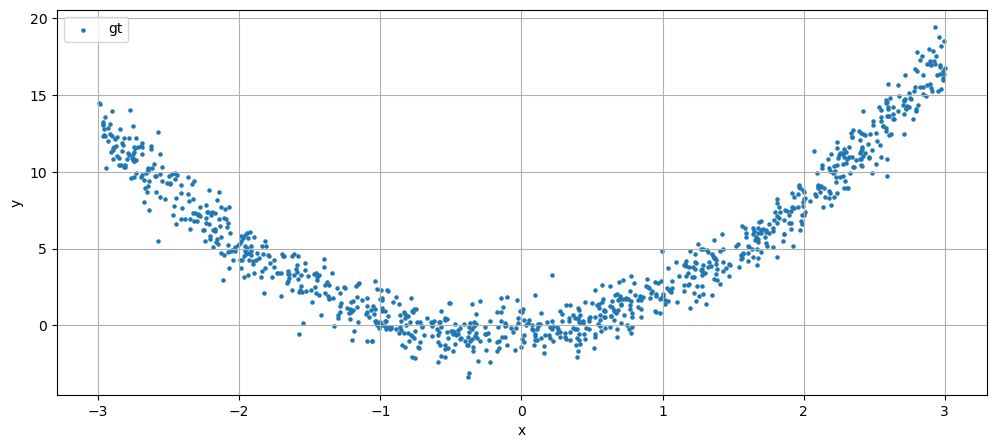

In [10]:
np.random.seed(1234)
_a = np.random.uniform(1, 5)
_b = np.random.uniform(-3, 3)
_c = np.random.uniform(-3, 3)

num_samples = 1000

xs = np.random.uniform(-3, 3, size=num_samples)
ys_clean = _a * xs**2 + _b * xs + _c
ys_noise = np.random.normal(0, 1, size=len(ys_clean))
ys = ys_clean + ys_noise

plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, label="gt", s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

In [11]:
class CustomDataset(Dataset):
    def __init__(self, xs, ys):
        super().__init__()

        if len(xs) != len(ys):
            raise ValueError(f"lens mismatch: {len(xs)} != {len(ys)}")

        self.xs = xs
        self.ys = ys

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, i):
        return (self.xs[i], self.ys[i])

    @staticmethod 
    def collate_fn(items_list):
        xs = torch.zeros(len(items_list), 1)
        ys = torch.zeros(len(items_list), 1)

        for i, (x, y) in enumerate(items_list):
            xs[i] = x
            ys[i] = y

        return xs, ys

`collate_fn` — это параметр `DataLoader`, а не часть `Dataset`. Он определяет, как несколько отдельных элементов, возвращаемых датасетом, объединяются в батч.

In [12]:
dataset = CustomDataset(xs, ys)
dataset[0]

(np.float64(1.712151502282615), np.float64(6.261151337822555))

In [13]:
next(iter(dataset))

(np.float64(1.712151502282615), np.float64(6.261151337822555))

In [14]:
dataset[1]

(np.float64(1.6798548487128215), np.float64(6.005594456243541))

In [15]:
len(dataset)

1000

In [16]:
dataset[100]

(np.float64(0.34656497056469693), np.float64(-0.9502726915332733))

По датасету можно итерироваться напрямую, однако в реальной практике это требуется достаточно редко:

In [17]:
for x in dataset[:2]:
    print(x, x.shape)

for x in dataset[:5]:
    print(x, x.shape)

[1.7121515  1.67985485] (2,)
[6.26115134 6.00559446] (2,)
[ 1.7121515   1.67985485 -1.36444437 -1.34121447  1.81123307] (5,)
[6.26115134 6.00559446 1.70076346 3.39949397 6.69226491] (5,)


Объекта типа `Dataset` действительно достаточно для доступа к данным, но для эффективного обучения необходима дополнительная логика, которую предоставляет `DataLoader`:

In [18]:
import os

#### Рекомендации по настройке `num_workers`

| Ситуация | Рекомендуемый `num_workers` | Обоснование |
| :--- | :--- | :--- |
| **Отладка кода** | `0` | Упрощает профилирование, исключает ошибки, связанные с многопроцессностью. |
| **Небольшой датасет, простые преобразования** | `2` или `4` | Слишком много воркеров не дадут прироста, но создадут нагрузку. |
| **Крупный датасет, сложные аугментации** | Постепенно увеличивать от `4` до `os.cpu_count() - 1` | Позволяет найти точку, где загрузка данных успевает за вычислениями на GPU. |
| **Нехватка оперативной памяти** | Уменьшить текущее значение | Снижает потребление RAM каждым процессом-воркером. |

In [19]:
# Правильно использовать os.cpu_count() как верхний предел
os.cpu_count()

16

In [20]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=32, # Ян Лекун берёт это значение по-умолчанию. Дальше исследование ;)
    shuffle=True,
    drop_last=False,
    collate_fn=dataset.collate_fn)

Длина `DataLoader`'а (количество итераций за эпоху) определяется количеством батчей, а не отдельных samples:

In [21]:
len(dataloader)

32

`DataLoader` является итерируемым объектом, но не поддерживает индексацию напрямую:

In [22]:
# dataloader[1]

In [23]:
print([tensor.shape for tensor in next(iter(dataloader))])

[torch.Size([32, 1]), torch.Size([32, 1])]


In [24]:
for batch in dataloader:
    xs, ys = batch
    print(xs.shape, ys.shape)
    break

torch.Size([32, 1]) torch.Size([32, 1])


Для глубокого понимания механизма работы `DataLoader` реализуем его упрощённую версию, демонстрирующую ключевые принципы формирования батчей:

**Задание:**
Реализуйте метод `__getitem__(self, i)`, который возвращает i-й батч данных.

**Требования к реализации:**

1.  **Структура батча:** Батч должен быть кортежем, где каждый элемент соответствует одному из типов данных, возвращаемых датасетом (обычно — данные и метки)
2.  **Формирование тензоров:** Каждый элемент батча должен быть тензором, объединяющим соответствующие элементы из отдельных samples
3.  **Размерность:** Длина каждого тензора в батче должна равняться `batch_size` (за исключением последнего батча при `drop_last=False`)
4.  **Использование collate_fn:** Для сборки отдельных samples в батч используйте метод `self.dataset.collate_fn`

In [25]:
class MyDataLoader:
    def __init__(self, dataset, batch_size, collate_fn):
        self.dataset = dataset
        self.batch_size = batch_size
        self.collate_fn = collate_fn

        self.indices = np.arange(len(dataset))

    def __len__(self):
        return len(dataset) // self.batch_size

    def __getitem__(self, i):
        # YOUR CODE HERE

        indices = self.indices[i*self.batch_size: (i+1)*self.batch_size]
        items = [self.dataset[i] for i in indices]
        batch = self.collate_fn(items)
        
        # END OF YOUR CODE

        return batch
    

In [26]:
my_dataloader = MyDataLoader(dataset,
                             batch_size=32,
                             collate_fn=dataset.collate_fn)

In [27]:
batch = my_dataloader[0]

assert len(batch) == 2
assert batch[0].shape == (32, 1)
assert batch[1].shape == (32, 1)

**Важное примечание о дополнительных параметрах DataLoader:**

Некоторые параметры `DataLoader`, критически важные для производительности в реальных задачах, были сознательно опущены в рамках этого вводного занятия:

```python
# Параметры для оптимизации производительности (рассмотрим отдельно)
dataloader = DataLoader(
    dataset,
    batch_size=32,
    # num_workers=4,    # Многопроцессная загрузка данных
    # pin_memory=True,  # Оптимизация передачи на GPU  
    # persistent_workers=True,  # Переиспользование процессов-воркеров
    # prefetch_factor=2,       # Предзагрузка батчей
)
```

### 1.2. Модель: `nn.Module`

Нейросетевые модели строятся как композиция слоёв, которые последовательно преобразуют входные данные. Каждый компонент сети должен наследоваться от базового класса `nn.Module`:

```python
import torch.nn as nn

# Примеры слоёв-наследников nn.Module
linear_layer = nn.Linear(100, 50)  # Линейный слой
conv_layer = nn.Conv2d(3, 64, 3)   # Свёрточный слой
activation = nn.ReLU()             # Функция активации
```

In [28]:
import torch.nn as nn

**Задание:**
Реализуйте недостающие части в классе нейросетевого слоя, наследуемого от `nn.Module`.
* В `__init__()` должны быть инициализированы матрица `self.weights` ($\text{out\_dim} \times \text{in\_dim}$) и вектор `bias` (или `None`).
* В `forward()` они должны быть применены ко входу `x` ($\text{batch} \times \text{in\_dim}$).

**Ключевой аспект:** Обратите внимание, что обработка всегда происходит по батчам. Даже для одного объекта вход будет иметь размерность ($1 \times \text{in\_dim}$).

В чём принципиальное отличие `nn.Module` от `autograd.Function`? ООП и переиспользование функций с реализованным дифференцированием.

In [29]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()

        # YOUR CODE HERE

        self.weight = nn.Parameter(torch.randn(out_features, in_features) / torch.sqrt(
            torch.tensor(in_features, dtype=torch.float32)))
        self.bias = nn.Parameter(torch.randn(out_features))
        
        # END OF YOUR CODE

    def forward(self, x):
        # YOUR CODE HERE

        output = x @ self.weight.T  # (B, in_features) x (out_features, in_features).T
        output = output + self.bias

        # END OF YOUR CODE

        return output

    def __repr__(self):
        return f"CustomLinear({self.weight.shape[1]}, {self.weight.shape[0]}, bias={self.bias is not None})"

In [30]:
linear = CustomLinear(8, 1)

batch_size = 5
x = torch.randn(batch_size, 8)

linear(x)

tensor([[ 0.2791],
        [-0.3815],
        [-0.7465],
        [ 0.8459],
        [ 0.3910]], grad_fn=<AddBackward0>)

In [31]:
linear = CustomLinear(8, 1)

assert isinstance(linear.weight, nn.Parameter)
assert isinstance(linear.bias, nn.Parameter)
assert linear.weight.shape == (1, 8)
assert linear.bias.shape == (1,)

In [32]:
print(linear)

CustomLinear(8, 1, bias=True)


In [33]:
# dir(nn.Module)

In [34]:
linear.requires_grad_(False) # подвергаются тензоры весов в nn.Parameter

CustomLinear(8, 1, bias=True)

**Исследуем функциональность, получаемую при наследовании от `nn.Module`:**

При наследовании от `nn.Module` класс автоматически получает ряд важных атрибутов и методов. Рассмотрим ключевые из них:

**1. Доступ к параметрам модели:**

In [35]:
for p in linear.parameters():
    print(p)
    print()

Parameter containing:
tensor([[ 0.3439,  0.2481,  0.7827, -0.0098,  0.3727,  0.2001, -0.1350,  0.3114]])

Parameter containing:
tensor([0.2710])



In [36]:
for p in linear.named_parameters():
    print(p)
    print()

('weight', Parameter containing:
tensor([[ 0.3439,  0.2481,  0.7827, -0.0098,  0.3727,  0.2001, -0.1350,  0.3114]]))

('bias', Parameter containing:
tensor([0.2710]))



In [37]:
linear.state_dict()

OrderedDict([('weight',
              tensor([[ 0.3439,  0.2481,  0.7827, -0.0098,  0.3727,  0.2001, -0.1350,  0.3114]])),
             ('bias', tensor([0.2710]))])

**Практика определения `__repr__` для улучшения читаемости и отладки:**

Для классов, наследуемых от `nn.Module`, рекомендуется реализовывать метод `__repr__()`, который предоставляет информативное строковое представление объекта:

In [38]:
print(linear)

CustomLinear(8, 1, bias=True)


**2. Режимы работы модели: обучение vs инференс**

Важным атрибутом классов-наследников `nn.Module` является индикатор `.training`, который указывает текущий режим работы модели:

In [39]:
linear.training

True

In [40]:
linear.eval()
linear.training

False

In [41]:
linear.train()
linear.training

True

**Важное замечание о режимах работы и вычислении градиентов:**

Переход модели в режим инференса (`.eval()`) **не отключает автоматическое вычисление градиентов**!

**Управление типами данных в нейросетевых моделях**

Как обсуждалось ранее, вычисления в PyTorch можно производить с различной точностью. Для этого необходимо привести параметры модели к соответствующему типу данных. Наследование от `nn.Module` предоставляет единый интерфейс для управления типами данных всех параметров модели:

In [42]:
linear.weight.device, linear.bias.device

(device(type='cpu'), device(type='cpu'))

In [43]:
linear.weight.dtype

torch.float32

In [44]:
linear = linear.half()

In [45]:
linear.weight.dtype

torch.float16

In [46]:
linear = linear.float()

In [47]:
linear.weight.dtype

torch.float32

In [48]:
linear = linear.to(device=device, dtype=torch.bfloat16)

In [49]:
linear.weight.dtype, linear.weight.device

(torch.bfloat16, device(type='mps', index=0))

**Определение устройства размещения модели в PyTorch**

В отличие от некоторых других фреймворков, PyTorch не предоставляет прямого атрибута для определения устройства, на котором размещена модель. Однако эту информацию можно получить несколькими способами:

In [50]:
linear = linear.to(device)

In [51]:
#linear.device

In [52]:
linear.weight.device

device(type='mps', index=0)

In [53]:
next(linear.parameters()).device

device(type='mps', index=0)

In [54]:
device = torch.device("cpu")

In [55]:
linear = linear.to(device)

Теперь перейдём к непосредственному использованию нашей модели для обработки данных:

In [56]:
x = torch.randn(32, 8)

In [57]:
linear = linear.to(dtype=torch.float32)

In [58]:
y = linear(x)
y.shape

torch.Size([32, 1])

In [59]:
x = torch.randn(32, 8)
y = linear(x) # ()
y.shape

torch.Size([32, 1])

### **1.3. Организация процесса обучения**

#### **1.3.1. Выбор и настройка оптимизатора**

In [60]:
import torch.optim as optim

In [61]:
linear = CustomLinear(8, 1)

In [62]:
param_groups = list(linear.named_parameters())
param_groups = [{"lr": 1e-3, "params": param_groups[0][1]}, {"params": param_groups[1][1]}]

In [63]:
param_groups

[{'lr': 0.001,
  'params': Parameter containing:
  tensor([[-0.5808,  0.0906,  0.0206, -0.4977,  0.1138, -0.3064,  0.3479, -0.1742]],
         requires_grad=True)},
 {'params': Parameter containing:
  tensor([0.0789], requires_grad=True)}]

In [64]:
optimizer = optim.SGD(
    param_groups,
    lr=1e-4
)

In [65]:
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [66]:
optimizer.param_groups

[{'lr': 0.001,
  'params': [Parameter containing:
   tensor([[-0.5808,  0.0906,  0.0206, -0.4977,  0.1138, -0.3064,  0.3479, -0.1742]],
          requires_grad=True)],
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'fused': None},
 {'params': [Parameter containing:
   tensor([0.0789], requires_grad=True)],
  'lr': 0.0001,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'fused': None}]

#### **1.3.2. Определение функции потерь**

**Варианты реализации функции потерь:**

**Можно реализовать самостоятельно:**

In [67]:
def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

In [68]:
xs, ys_true = next(iter(dataloader))

In [69]:
ys_pred = torch.randn_like(ys_true)

In [70]:
mse_loss(ys_true, ys_pred)

tensor(64.4204)

**Можно использовать готовые реализации из PyTorch:**

In [71]:
from torch.nn.functional import mse_loss as torch_mse_loss

In [72]:
torch_mse_loss(ys_true, ys_pred)

tensor(64.4204)

#### **1.3.3. Организация цикла обучения**

**Задание:** Реализовать функцию обучения модели на одной эпохе.

**Требуемая функциональность:**
* Получение предсказаний модели для объектов из текущего батча
* Вычисление значения функции потерь
* Выполнение обратного распространения ошибки и обновление весов модели

In [73]:
def train_epoch(model, dataloader, optimizer, loss_fn, epoch):
    model.train()

    losses = []
    for batch in dataloader:
        xs, ys_true = batch
        xs = xs.to(device)
        ys_true = ys_true.to(device)

        # YOUR CODE HERE

        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys_true)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # END OF YOUR CODE

        losses.append(loss.item())

    return np.mean(losses)

**Дополнительный функционал для валидации:**
На этапе валидации мы также будем сохранять результаты предсказаний для последующей визуализации и анализа качества модели.

In [74]:
@torch.inference_mode()
def val_epoch(model, dataloader, loss_fn):
    model.eval()

    losses = []
    preds = []
    for batch in dataloader:
        xs, ys_true = batch
        xs = xs.to(device)
        ys_true = ys_true.to(device)
        ys_pred = model(xs)

        loss = loss_fn(ys_pred, ys_true)
        losses.append(loss.item())

        preds.append(ys_pred.detach().cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    return np.mean(losses), preds

### **2. Процесс обучения модели**

#### **2.1. Базовый подход (Baseline)**

Начнем с простейшей архитектуры — одного полносвязного слоя, что по сути соответствует аппроксимации данных линейной функцией.

In [75]:
import tqdm

In [76]:
num_epochs = 128
lr = 8e-4
batch_size = 8

train_size = 800

In [77]:
xs = np.random.uniform(-3, 3, size=num_samples)
ys_clean = _a * xs**2 + _b * xs + _c
ys_noise = np.random.normal(0, 1, size=len(ys_clean))
ys = ys_clean + ys_noise

train_dataset = CustomDataset(xs[:train_size], ys[:train_size])
val_dataset = CustomDataset(xs[train_size:], ys[train_size:])

In [78]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True
)

val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=train_dataset.collate_fn, drop_last=False
)

In [79]:
device = torch.device("cpu")

In [80]:
model = CustomLinear(1, 1).to(device)

In [81]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [82]:
loss_fn = mse_loss

In [83]:
losses = []
val_losses = []
val_preds = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)

    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)
    val_preds.append(preds)

100%|██████████| 128/128 [00:07<00:00, 16.29it/s]


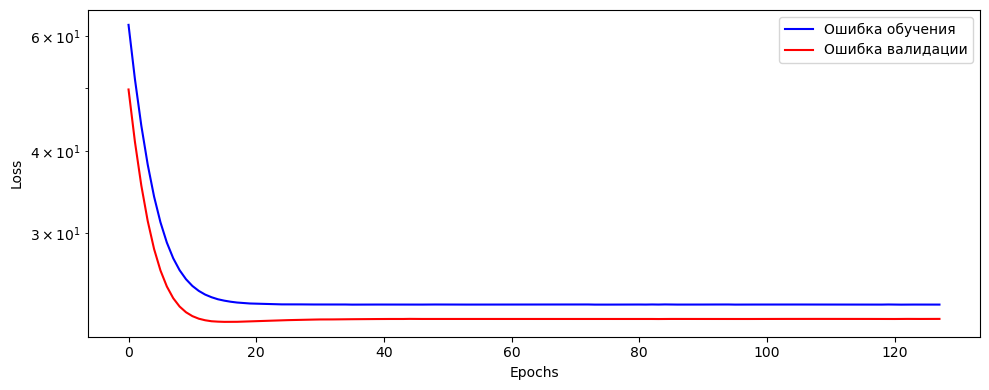

In [84]:
fig = plot_losses(losses, val_losses)

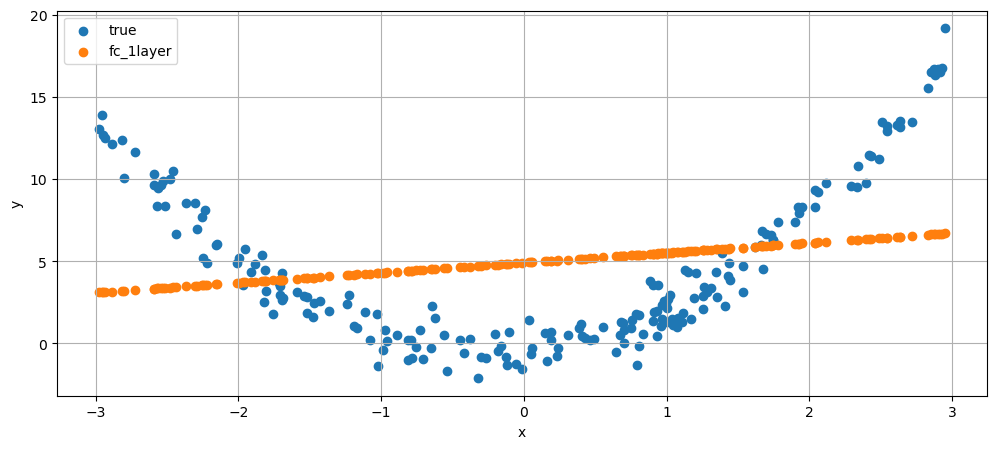

In [85]:
plt.figure(figsize=(12, 5))
plt.scatter(xs[train_size:], ys[train_size:], label="true")
plt.scatter(xs[train_size:], val_preds[-1], label="fc_1layer")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [86]:
fc_1layer_train_losses = losses
fc_1layer_val_losses = val_losses
fc_1layer_preds = preds

#### **2.2. Усложнение архитектуры**

In [87]:
from torch.nn import Sequential
from torch.nn import ReLU

**Задание**: Создайте двухслойную нейронную сеть со следующими характеристиками:
- Первый слой: (1, 4) — 1 входной признак, 4 нейрона в скрытом слое
- Второй слой: (4, 1) — 4 входа, 1 выходной нейрон
- Между слоями добавьте нелинейную функцию активации ReLU

In [88]:
# YOUR CODE HERE
model = nn.Sequential(
    CustomLinear(1, 4),
    nn.ReLU(inplace=True), # так сохраняем память на backward'e,
    CustomLinear(4, 1)
)
# END OF YOUR CODE

In [89]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [90]:
losses = []
val_losses = []
val_preds = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)

    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)
    val_preds.append(preds)

100%|██████████| 128/128 [00:06<00:00, 18.78it/s]


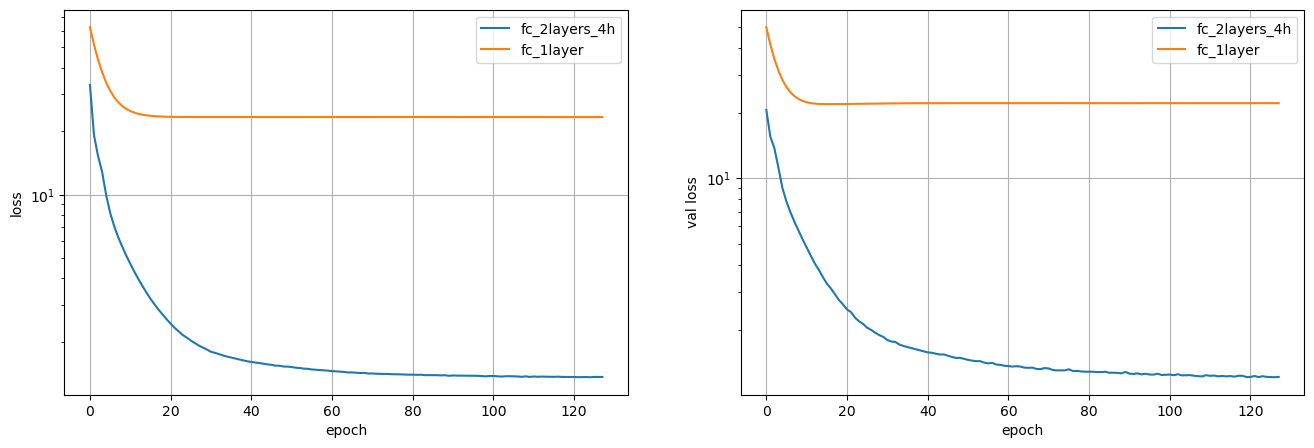

In [91]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.semilogy(losses, label="fc_2layers_4h")
plt.semilogy(fc_1layer_train_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.semilogy(val_losses, label="fc_2layers_4h")
plt.semilogy(fc_1layer_val_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("val loss")

plt.show()

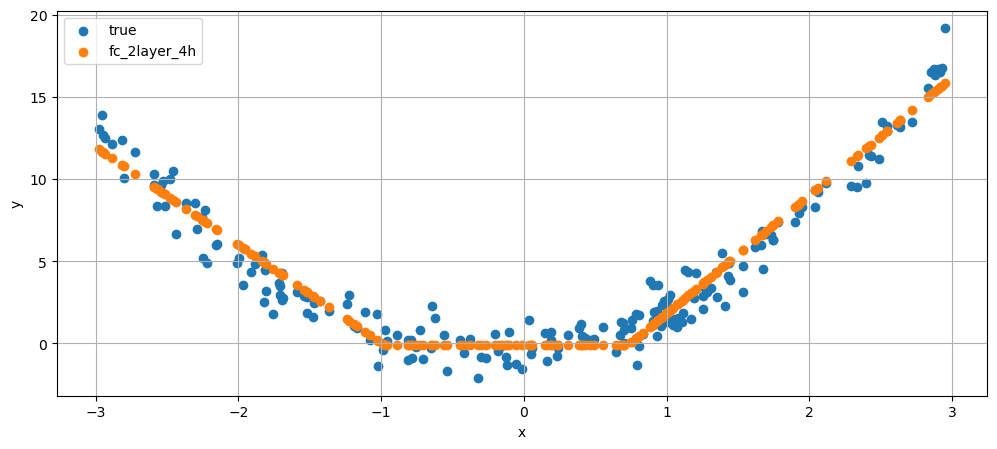

In [92]:
plt.figure(figsize=(12, 5))
plt.scatter(xs[train_size:], ys[train_size:], label="true")
plt.scatter(xs[train_size:], val_preds[-1], label="fc_2layer_4h")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [93]:
fc_2layer_4h_train_losses = losses
fc_2layer_4h_val_losses = val_losses
fc_2layer_4h_preds = preds

**Эксперимент с увеличением емкости модели:** <br>
Увеличим количество нейронов в скрытом слое для повышения выразительной способности модели.

In [94]:
layers = [CustomLinear(1, 16), ReLU(inplace=True), CustomLinear(16, 1)]

model = Sequential(*layers)
model

Sequential(
  (0): CustomLinear(1, 16, bias=True)
  (1): ReLU(inplace=True)
  (2): CustomLinear(16, 1, bias=True)
)

In [95]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [96]:
losses = []
val_losses = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)

    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)

100%|██████████| 128/128 [00:06<00:00, 19.14it/s]


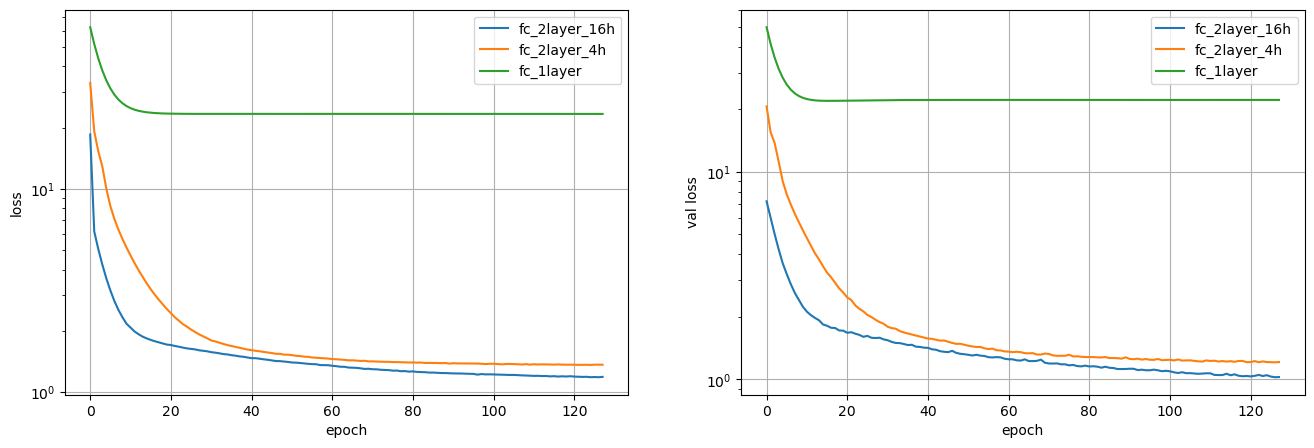

In [97]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.semilogy(losses, label="fc_2layer_16h")
plt.semilogy(fc_2layer_4h_train_losses, label="fc_2layer_4h")
plt.semilogy(fc_1layer_train_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.semilogy(val_losses, label="fc_2layer_16h")
plt.semilogy(fc_2layer_4h_val_losses, label="fc_2layer_4h")
plt.semilogy(fc_1layer_val_losses, label="fc_1layer")
plt.grid(True)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("val loss")

plt.show()

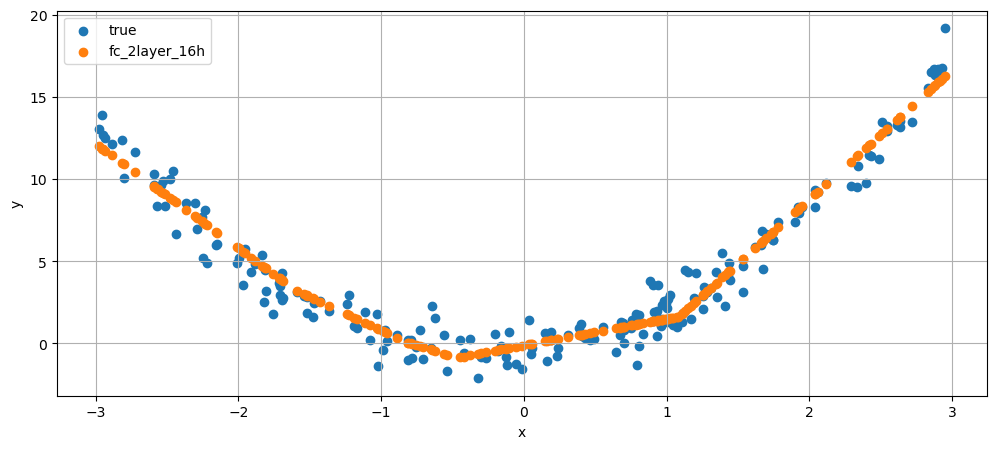

In [98]:
plt.figure(figsize=(12, 5))
plt.scatter(xs[train_size:], ys[train_size:], label="true")
plt.scatter(xs[train_size:], preds, label="fc_2layer_16h")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

**Наблюдения:** <br>
Полученная модель демонстрирует кусочно-линейное поведение, характерное для комбинации линейных слоев с функцией ReLU. Интересные визуализации, поясняющие этот феномен, можно найти [здесь](http://neuralnetworksanddeeplearning.com/chap4.html).

**Аналитическое обсуждение:**

Исходные данные были сгенерированы с использованием всего трех параметров (a, b, c), которые полностью определяют поведение целевой квадратичной функции (за исключением случайного шума). Однако для аппроксимации этих данных потребовалась нейронная сеть со значительно большим количеством параметров.

**Вопрос для размышления:**
- Сколько именно параметров потребовалось в нашей модели?
- Почему для аппроксимации простой квадратичной функции требуется如此 много параметров?
- Можно ли оптимизировать этот процесс?

**Теоретическая основа:**
Для углубленного изучения данной проблематики рекомендуется ознакомиться с:
- [Граница Яроцкого (Yarotsky Bound)](https://arxiv.org/abs/1610.01145) — теоретическое обоснование оптимальной аппроксимации квадратичной функции нейронными сетями
- [Законы масштабирования (Scaling Laws)](https://arxiv.org/abs/2001.08361) — исследования зависимости эффективности моделей от их размера

Этот анализ поднимает фундаментальные вопросы о эффективности параметризации и оптимальной архитектуре нейронных сетей для решения различных классов задач.

## **3. Работа с моделью: сохранение и загрузка**

Обученные параметры модели важно сохранять для последующего использования — инференса, дообучения или развертывания.

In [99]:
print(model)

Sequential(
  (0): CustomLinear(1, 16, bias=True)
  (1): ReLU(inplace=True)
  (2): CustomLinear(16, 1, bias=True)
)


В PyTorch для этого используется механизм `state_dict`, который представляет собой словарь с параметрами модели:

In [100]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[ 0.3731],
        [-1.1255],
        [-0.6780],
        [-0.0307],
        [-0.1972],
        [ 2.7356],
        [ 1.5145],
        [-0.1396],
        [-0.0206],
        [-1.2099],
        [ 0.1592],
        [-1.4922],
        [ 0.4558],
        [-0.0624],
        [-0.1556],
        [-2.3380]])), ('0.bias', tensor([ 0.0946,  1.3221, -1.0809, -1.7027, -0.5929, -2.9809,  1.2638, -2.1966,
         0.9570, -1.9330, -0.3030, -0.6756, -1.5722,  0.6987, -0.8179, -1.1076])), ('2.weight', tensor([[-0.1429, -0.2464,  1.1807,  0.0562, -0.2267,  2.3743,  0.8811, -0.2937,
         -0.6905,  1.2387,  0.3075,  0.7662,  0.0893, -0.5177,  0.1188,  1.3881]])), ('2.bias', tensor([0.1391]))])


### **3.1. Сохранение модели**

In [101]:
output_fn = "./state_dict.pth.tar"

In [102]:
with open(output_fn, "wb") as fp:
    torch.save(model.state_dict(), fp)

### **3.2. Загрузка модели**

In [103]:
model = Sequential(CustomLinear(1, 16), ReLU(inplace=True), CustomLinear(16, 1))

In [104]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[ 1.7496e+00],
        [ 1.9481e+00],
        [-2.3231e-04],
        [-4.1481e-02],
        [ 1.6028e-01],
        [-7.4290e-01],
        [-1.0349e+00],
        [-5.5120e-01],
        [-3.5135e-01],
        [ 5.0822e-01],
        [ 2.3828e-01],
        [ 5.4325e-01],
        [-6.4696e-01],
        [ 2.3792e-01],
        [-1.1839e+00],
        [-3.1790e-01]])), ('0.bias', tensor([ 0.4279,  1.1632, -0.8327,  0.1787,  0.9534, -0.7600, -0.5754,  0.6733,
         1.2297, -1.9892,  0.3693,  0.1547,  1.1352,  1.7259, -0.2545, -0.4402])), ('2.weight', tensor([[ 0.0229,  0.2042,  0.2197,  0.1048,  0.0308, -0.0621, -0.0968,  0.3570,
         -0.0466,  0.4112, -0.0306,  0.0246,  0.0927,  0.1454,  0.1091,  0.1265]])), ('2.bias', tensor([0.3395]))])


In [105]:
with open(output_fn, "rb") as fp:
    state_dict = torch.load(fp, map_location="cpu", )
state_dict

/var/folders/97/_c6jz2ls7dg064cmjfvhkvhw0000gn/T/ipykernel_12347/430348479.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fp, map_location="cpu"

OrderedDict([('0.weight',
              tensor([[ 0.3731],
                      [-1.1255],
                      [-0.6780],
                      [-0.0307],
                      [-0.1972],
                      [ 2.7356],
                      [ 1.5145],
                      [-0.1396],
                      [-0.0206],
                      [-1.2099],
                      [ 0.1592],
                      [-1.4922],
                      [ 0.4558],
                      [-0.0624],
                      [-0.1556],
                      [-2.3380]])),
             ('0.bias',
              tensor([ 0.0946,  1.3221, -1.0809, -1.7027, -0.5929, -2.9809,  1.2638, -2.1966,
                       0.9570, -1.9330, -0.3030, -0.6756, -1.5722,  0.6987, -0.8179, -1.1076])),
             ('2.weight',
              tensor([[-0.1429, -0.2464,  1.1807,  0.0562, -0.2267,  2.3743,  0.8811, -0.2937,
                       -0.6905,  1.2387,  0.3075,  0.7662,  0.0893, -0.5177,  0.1188,  1.3881]])),
        

In [106]:
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [107]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3731],
                      [-1.1255],
                      [-0.6780],
                      [-0.0307],
                      [-0.1972],
                      [ 2.7356],
                      [ 1.5145],
                      [-0.1396],
                      [-0.0206],
                      [-1.2099],
                      [ 0.1592],
                      [-1.4922],
                      [ 0.4558],
                      [-0.0624],
                      [-0.1556],
                      [-2.3380]])),
             ('0.bias',
              tensor([ 0.0946,  1.3221, -1.0809, -1.7027, -0.5929, -2.9809,  1.2638, -2.1966,
                       0.9570, -1.9330, -0.3030, -0.6756, -1.5722,  0.6987, -0.8179, -1.1076])),
             ('2.weight',
              tensor([[-0.1429, -0.2464,  1.1807,  0.0562, -0.2267,  2.3743,  0.8811, -0.2937,
                       -0.6905,  1.2387,  0.3075,  0.7662,  0.0893, -0.5177,  0.1188,  1.3881]])),
        

Кроме параметров модели, часто полезно сохранять состояние других объектов обучения — например, оптимизатора (для возобновления обучения с прерванного места):

In [108]:
def save_checkpoint(model, optimizer, output_fn):
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}

    with open(output_fn, "wb") as fp:
        torch.save(checkpoint, output_fn)


def load_checkpoint(checkpoint_fn, model, optimizer):
    with open(checkpoint_fn, "rb") as fp:
        checkpoint = torch.load(fp, map_location="cpu")

    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [109]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
optimizer.param_groups[0]["lr"] = 1e-10
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-10
    maximize: False
    weight_decay: 0
)

In [110]:
checkpoint_fn = "./checkpoint.pth.tar"

In [111]:
save_checkpoint(model, optimizer, checkpoint_fn)

In [112]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

In [113]:
load_checkpoint(checkpoint_fn, model, optimizer)

/var/folders/97/_c6jz2ls7dg064cmjfvhkvhw0000gn/T/ipykernel_12347/2563314619.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location="cp

In [114]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-10
    maximize: False
    weight_decay: 0
)

## **4. Практический пример: классификация изображений MNIST**

Знакомство с датасетом MNIST стало практически обязательным в курсах по глубокому обучению.

In [115]:
import os
import glob
import matplotlib.pyplot as plt

In [116]:
#!pip install opencv-python

In [117]:
import cv2

MNIST — классический датасет изображений рукописных цифр, на котором мы построим минимальный рабочий пример обработки изображений.

Хотя датасет доступен через `torchvision.datasets.MNIST`, для наглядности мы обработаем его с помощью собственного класса.

In [118]:
import torchvision

torchvision.datasets.MNIST

torchvision.datasets.mnist.MNIST

In [119]:
!wget https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
!tar -xzf mnist_png.tar.gz
!ls mnist_png/

--2025-10-04 11:26:05--  https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz [following]
--2025-10-04 11:26:06--  https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15683414 (15M) [application/octet-stream]
Saving to: ‘mnist_png.tar.gz.2’

mnist_png.tar.gz.2  100%[===================>]  14,96M  2,68MB/s    in 5,6s    

2025-10-04 11:26:12 (2,69 MB/s) - ‘mnist_png.tar.gz.2’ saved [15683414/15683414]

testing  training


В отличие от рассмотренного ранее датасета, здесь мы передаем не данные напрямую, а путь к папке с файлами, предполагая известную структуру (`split/digit/*.png`).

In [120]:
class MNISTDataset(Dataset):
    def __init__(self, root_dir):
        self.images_filenames = []
        self.class_labels = []
        for class_label in os.listdir(root_dir):
            for image_basename in os.listdir(os.path.join(root_dir, class_label)):
                if not image_basename.endswith(".png"):
                    continue
                image_filename = os.path.join(root_dir, class_label, image_basename)
                self.images_filenames.append(image_filename)
                self.class_labels.append(int(class_label))

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, i):
        image = cv2.imread(self.images_filenames[i], cv2.IMREAD_GRAYSCALE)
        label = self.class_labels[i]
        return image, label

    @staticmethod
    def collate_fn(items):
        images = []
        labels = []
        for image, label in items:
            image = image / 255.0
            images.append(image.ravel())
            labels.append(label)
        return torch.tensor(np.array(images)).float(), torch.tensor(np.array(labels)).long()

In [121]:
train_dataset = MNISTDataset(root_dir="mnist_png/training")
len(train_dataset)

60000

Изучим примеры данных из датасета:

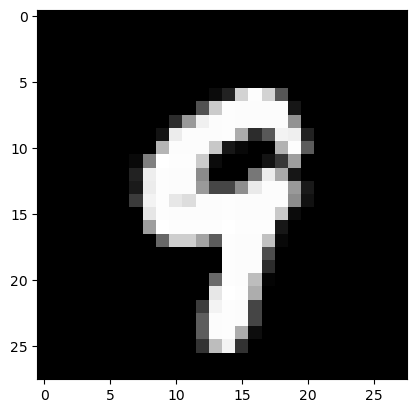

In [122]:
image, label = train_dataset[0]
plt.imshow(image, cmap="gray")
plt.show()

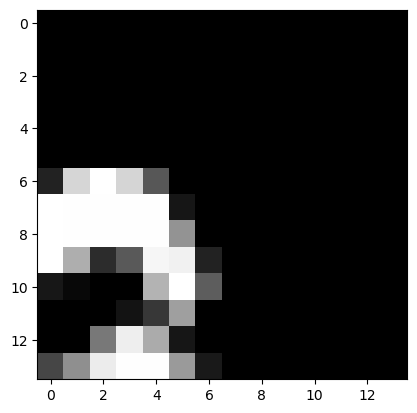

In [123]:
plt.imshow(image[:14, -14:], cmap="gray")

Вспомогательная функция для групповой визуализации изображений:

In [124]:
def show_images_with_captions(images, captions=None, ncol=8):
    nrow = len(images) // ncol

    plt.figure(figsize=(16, 16 * nrow // ncol))
    for i in range(len(images)):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(images[i], cmap="gray")
        if captions is not None:
            plt.title(captions[i])
        plt.grid(False)
        plt.axis(False)
    plt.show()

In [125]:
sample_indices = np.random.choice(len(train_dataset), size=64, replace=False)

sample_images = []
sample_captions = []
for i in sample_indices:
    image, label = train_dataset[i]
    sample_images.append(image)
    sample_captions.append(f"gt: {label}")

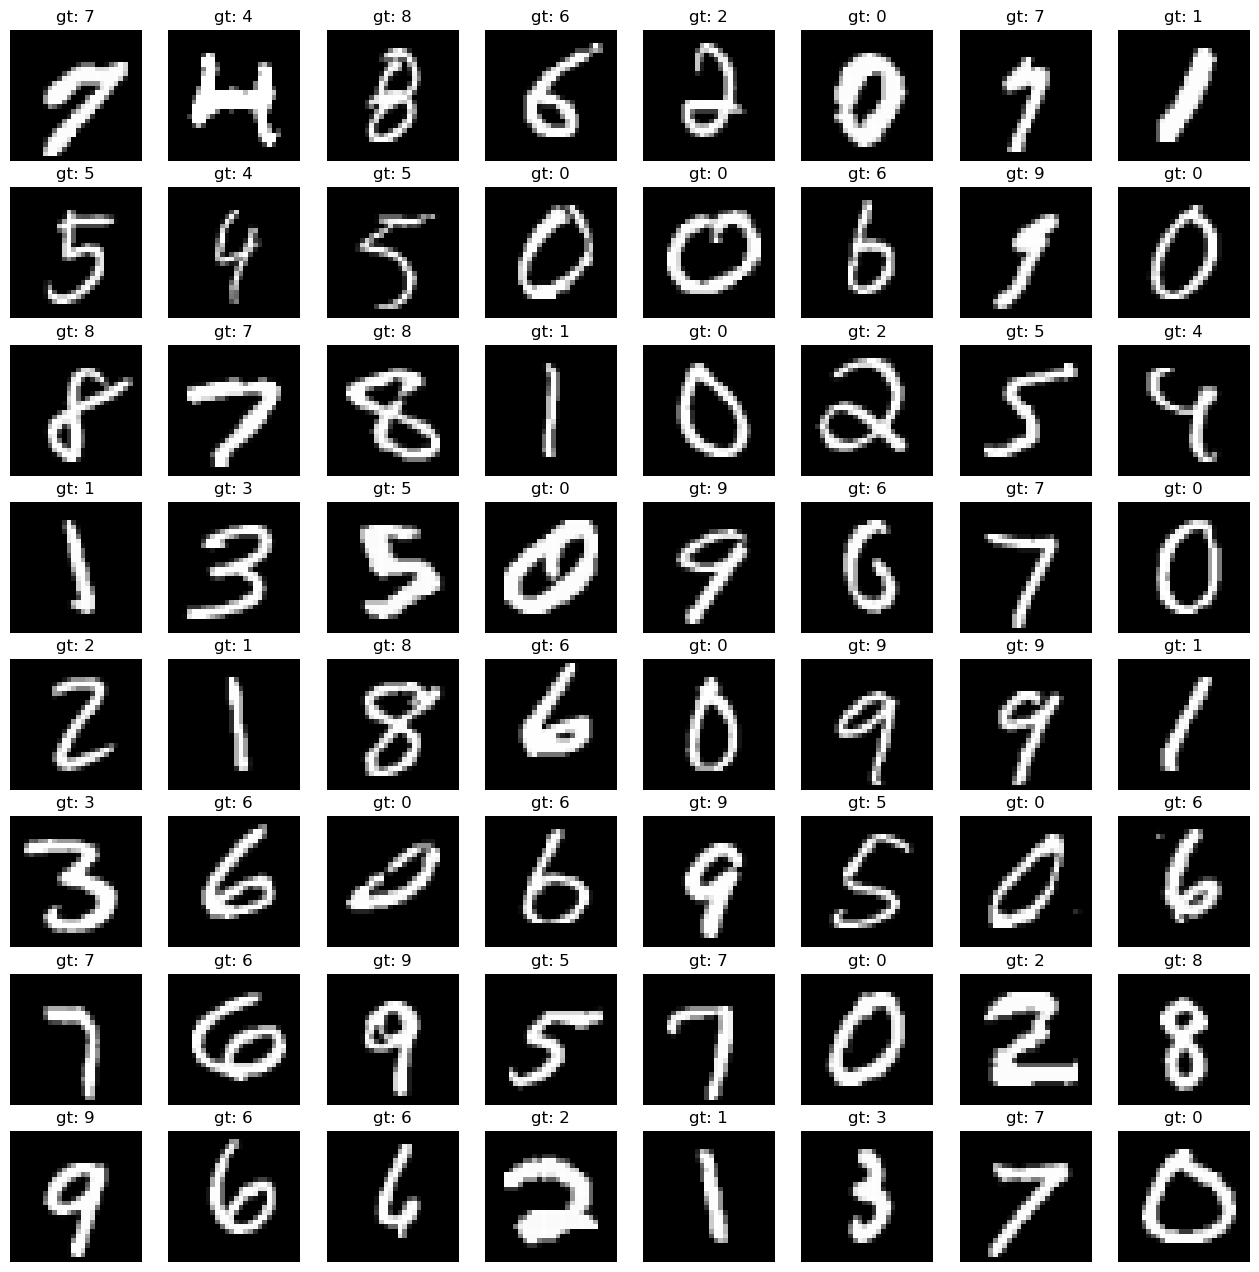

In [126]:
show_images_with_captions(sample_images, sample_captions)

Создадим более глубокую архитектуру (3 слоя) с использованием `BatchNorm1d`:

In [127]:
num_epochs = 5
batch_size = 100
lr = 3e-4

# device = torch.device("cpu")
device = torch.device("mps")
# device = torch.device("cuda:0")

In [128]:
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train_dataset.collate_fn
)

val_dataset = MNISTDataset(root_dir="mnist_png/testing/")
val_dataloader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=train_dataset.collate_fn
)

In [129]:
model = Sequential(
    CustomLinear(28 * 28, 512),
    nn.BatchNorm1d(512),
    ReLU(inplace=True),
    CustomLinear(512, 1024),
    nn.BatchNorm1d(1024),
    ReLU(inplace=True),
    CustomLinear(1024, 10),
).to(device)

In [130]:
optimizer = optim.Adam(model.parameters(), lr=lr)

В качестве функции потерь используем готовую реализацию (собственную реализацию предстоит написать в домашнем задании):

In [131]:
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss()

Функции для обучения и валидации остаются прежними — пока они удовлетворяют нашим потребностям:


In [132]:
losses = []
val_losses = []
val_preds = []
for epoch in tqdm.trange(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, loss_fn, epoch)
    losses.append(loss)

    val_loss, preds = val_epoch(model, val_dataloader, loss_fn)
    val_losses.append(val_loss)
    val_preds.append(preds)

100%|██████████| 5/5 [01:56<00:00, 23.26s/it]


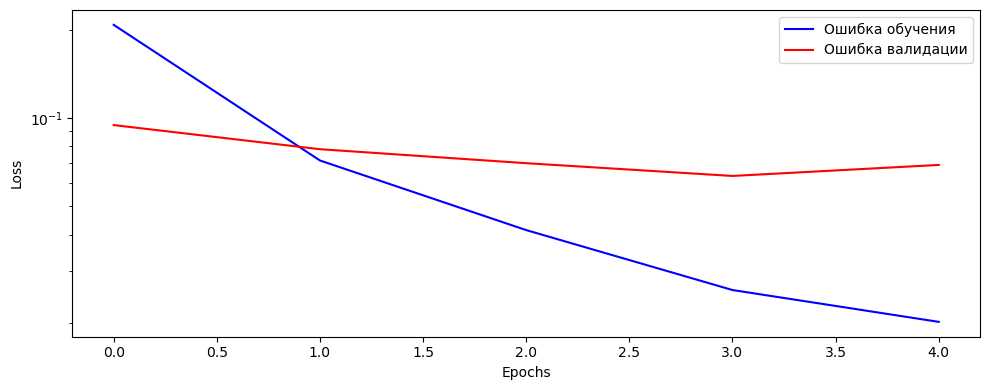

In [133]:
fig = plot_losses(losses, val_losses)

Соберем все предсказания и истинные метки для вычисления Accuracy и визуализации результатов:

In [134]:
val_pred_labels = []
for val_pred in val_preds[-1]:
    pred_label = np.argmax(val_pred)
    val_pred_labels.append(pred_label)
val_pred_labels = np.asarray(val_pred_labels)

In [135]:
val_labels = []
for image, label in val_dataset:
    val_labels.append(label)
val_labels = np.asarray(val_labels)

In [136]:
acc = (val_pred_labels == val_labels).mean()
acc

np.float64(0.9794)

In [137]:
sample_indices = np.random.choice(len(val_dataset), size=64, replace=False)

sample_images = []
sample_captions = []
for i in sample_indices:
    image, label = val_dataset[i]
    pred_label = val_pred_labels[i]
    sample_images.append(image)
    sample_captions.append(f"gt: {label} | pred: {pred_label}")

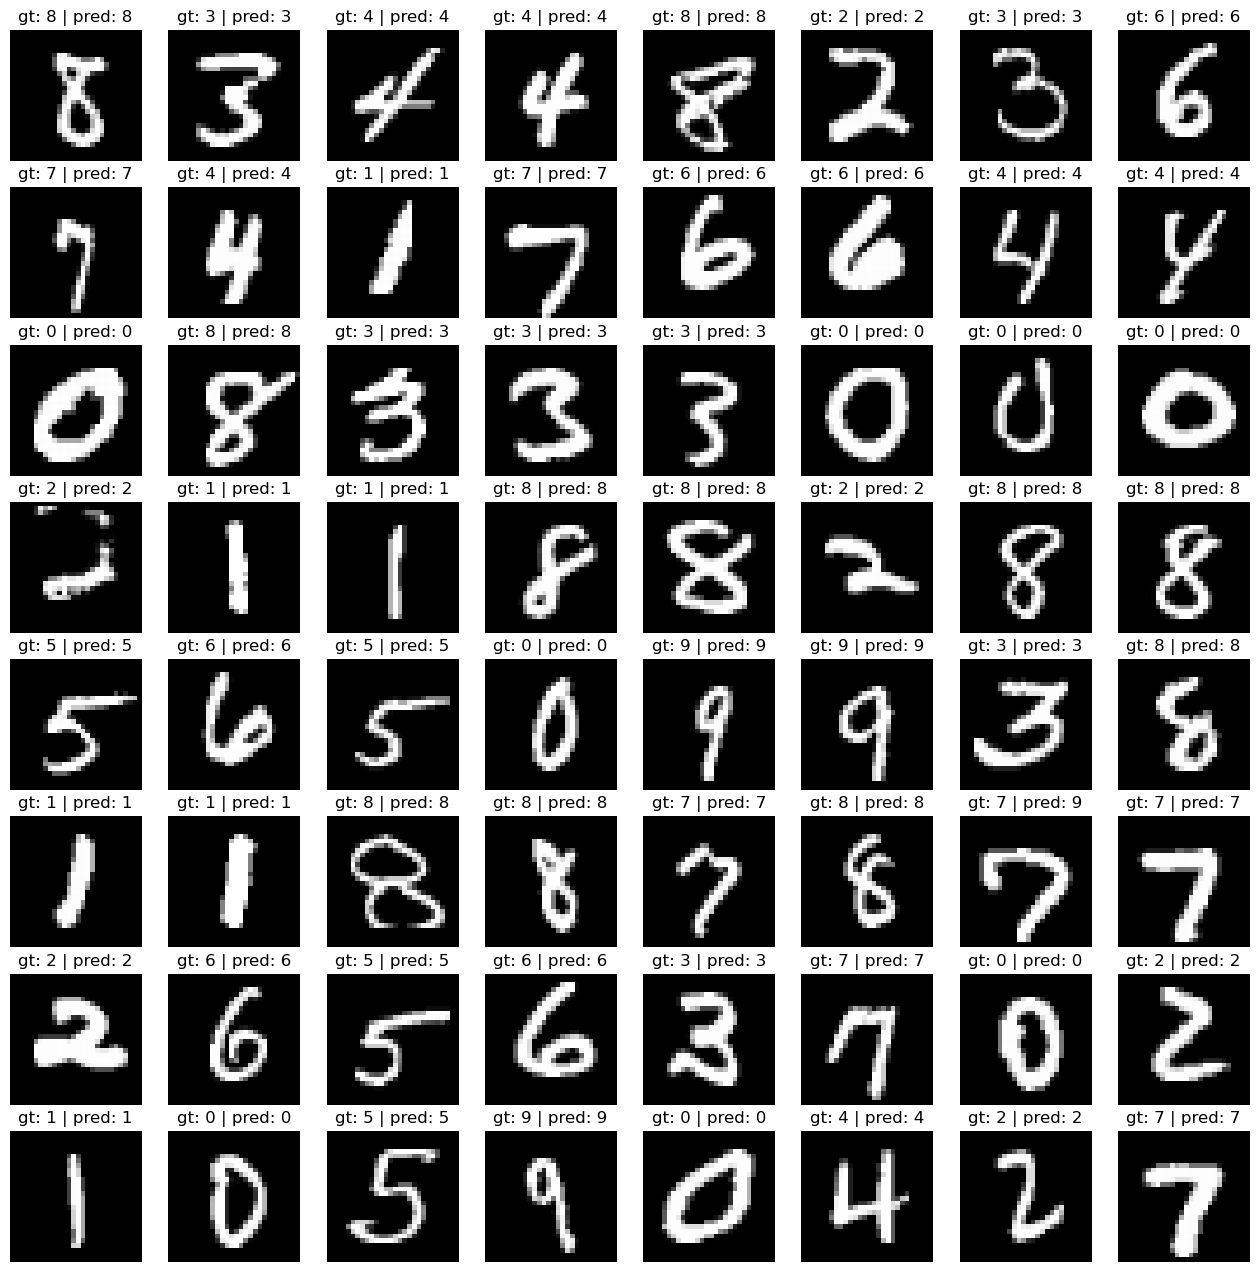

In [138]:
show_images_with_captions(sample_images, sample_captions)

Отдельно визуализируем примеры из валидационной выборки, на которых модель допускает ошибки:

In [139]:
sample_indices = np.random.choice(np.where(val_labels != val_pred_labels)[0], size=64, replace=False)

sample_images = []
sample_captions = []
for i in sample_indices:
    image, label = val_dataset[i]
    pred_label = val_pred_labels[i]
    sample_images.append(image)
    sample_captions.append(f"gt: {label} | pred: {pred_label}")

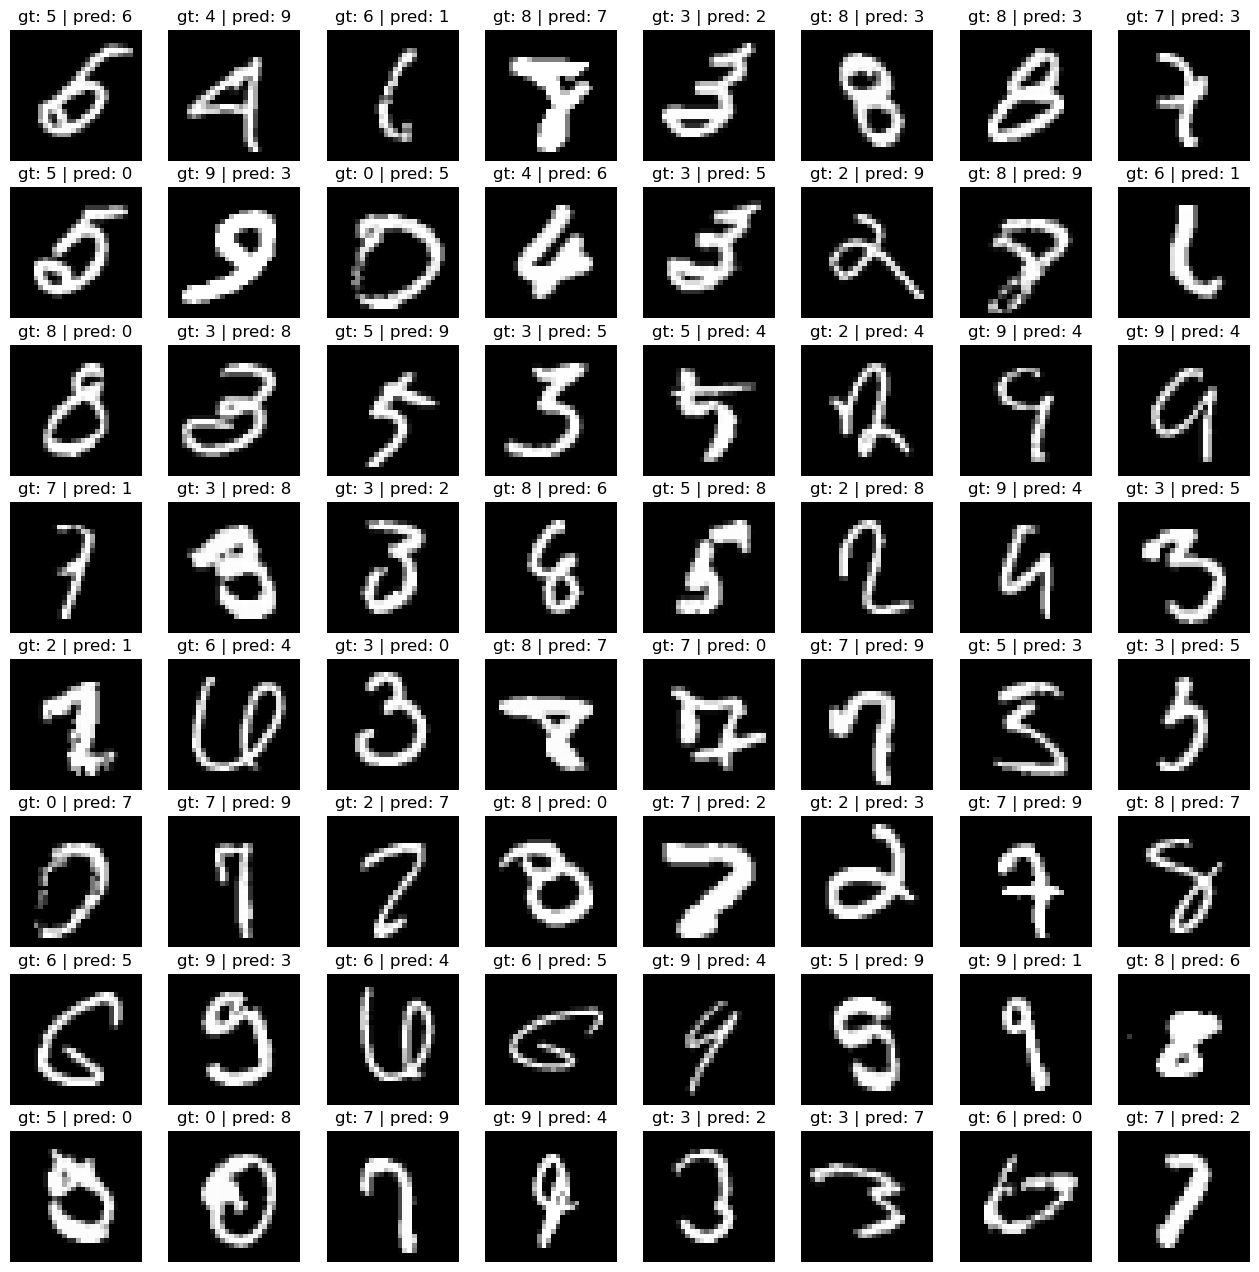

In [140]:
show_images_with_captions(sample_images, sample_captions)

## **Итоги семинара**

* Ознакомились с базовыми компонентами PyTorch для обучения нейронных сетей
* Реализовали пользовательские классы `Dataset` и `Model`
* Разработали собственную функцию активации с методом `backward()`

**В следующем семинаре:**
* Сверточные операции и сверточные нейронные сети